In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import requests
import scipy.stats as sps
import arviz as az

az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
start_date = '2020-03-01'
end_date = '2020-09-13'

url = 'https://covidtrackerapi.bsg.ox.ac.uk/api/v2/stringency/date-range/{}/{}'.format(start_date,end_date)

r = requests.get(url,timeout=5.0)
r.status_code

200

In [4]:
keys = pd.date_range(start_date,end_date)
keys

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2020-09-04', '2020-09-05', '2020-09-06', '2020-09-07',
               '2020-09-08', '2020-09-09', '2020-09-10', '2020-09-11',
               '2020-09-12', '2020-09-13'],
              dtype='datetime64[ns]', length=197, freq='D')

In [5]:
json = r.json()
data = json['data']
countries = json['countries']

In [6]:
data_list = []

for k in keys:
    date = k.date().strftime('%Y-%m-%d')
    for c in countries:
        try:
            data_list.append((date,c,data[date][c]['confirmed'],data[date][c]['deaths'],data[date][c]['stringency']))
        except KeyError:
            pass

In [7]:
df = pd.DataFrame(data_list,columns=['date','country','confirmed','dead','oxford_stringency'])
df['date'] = pd.to_datetime(df['date'])
df.set_index(['country','date'],inplace=True)
df.loc['GBR']

confirmed     dead  oxford_stringency
date                                             
2020-03-01       42.0      0.0              11.11
2020-03-02       47.0      0.0              11.11
2020-03-03       69.0      0.0              11.11
2020-03-04      109.0      0.0              11.11
2020-03-05      164.0      0.0              11.11
...               ...      ...                ...
2020-09-09   352560.0  41586.0              62.50
2020-09-10   355219.0  41594.0              62.50
2020-09-11   358138.0  41608.0              62.50
2020-09-12   361677.0  41614.0              62.50
2020-09-13   365174.0  41623.0              62.50

[197 rows x 3 columns]

In [8]:
average_ox_idx = df['oxford_stringency'].groupby(level=0).mean()
average_ox_idx

country
ABW    49.462944
AFG    68.872872
AGO    70.834112
AIA    41.165568
ALB    68.540895
         ...    
VUT    58.205596
YEM    40.551218
ZAF    74.761117
ZMB    46.031980
ZWE    72.804873
Name: oxford_stringency, Length: 185, dtype: float64

In [9]:
population = pd.read_csv('world_pop.csv',sep=';',thousands=',',header=None,index_col=0)
population.columns=['pop']
population.index.name='country'
population

pop
country                  
Afghanistan      38928346
Albania           2877797
Algeria          43851044
American Samoa      55191
Andorra             77265
...                   ...
Wallis & Futuna     11239
Western Sahara     597339
Yemen            29825964
Zambia           18383955
Zimbabwe         14862924

[240 rows x 1 columns]

In [10]:
three_letter_abb = pd.read_csv('three_letter_country_abb.csv',sep=';',header=None,index_col=2)
three_letter_abb = three_letter_abb[0]
three_letter_abb.loc['GBR']

'UK'

In [11]:
df = df.reset_index(level=1)

In [12]:
df.loc['GBR']

date  confirmed     dead  oxford_stringency
country                                                  
GBR     2020-03-01       42.0      0.0              11.11
GBR     2020-03-02       47.0      0.0              11.11
GBR     2020-03-03       69.0      0.0              11.11
GBR     2020-03-04      109.0      0.0              11.11
GBR     2020-03-05      164.0      0.0              11.11
...            ...        ...      ...                ...
GBR     2020-09-09   352560.0  41586.0              62.50
GBR     2020-09-10   355219.0  41594.0              62.50
GBR     2020-09-11   358138.0  41608.0              62.50
GBR     2020-09-12   361677.0  41614.0              62.50
GBR     2020-09-13   365174.0  41623.0              62.50

[197 rows x 4 columns]

In [13]:
df = df.join(three_letter_abb)

In [14]:
df.rename(columns={0 : 'country'},inplace=True)

In [15]:
df = df.join(average_ox_idx,lsuffix='_current',rsuffix='_mean')

In [16]:
df

date  confirmed   dead  oxford_stringency_current   country  \
ABW 2020-03-01        NaN    NaN                       0.00     Aruba   
ABW 2020-03-02        NaN    NaN                       0.00     Aruba   
ABW 2020-03-03        NaN    NaN                       0.00     Aruba   
ABW 2020-03-04        NaN    NaN                       0.00     Aruba   
ABW 2020-03-05        NaN    NaN                       0.00     Aruba   
..         ...        ...    ...                        ...       ...   
ZWE 2020-09-09     7388.0  218.0                      80.56  Zimbabwe   
ZWE 2020-09-10     7429.0  222.0                      80.56  Zimbabwe   
ZWE 2020-09-11     7453.0  222.0                      80.56  Zimbabwe   
ZWE 2020-09-12     7479.0  224.0                      80.56  Zimbabwe   
ZWE 2020-09-13     7508.0  224.0                      80.56  Zimbabwe   

     oxford_stringency_mean  
ABW               49.462944  
ABW               49.462944  
ABW               49.462944  
ABW               49.462944  
ABW               49.462944  
..                      ...  
ZWE               72.804873  
ZWE               72.804873  
ZWE               72.804873  
ZWE               72.804873  
ZWE               72.804873  

[37839 rows x 6 columns]

In [17]:
foo = df.merge(population,left_on='country',right_on=population.index)
foo['dead_per_M'] = foo['dead'] / (foo['pop'] / 1e6)
foo

date  confirmed   dead  oxford_stringency_current   country  \
0     2020-03-01        NaN    NaN                       0.00     Aruba   
1     2020-03-02        NaN    NaN                       0.00     Aruba   
2     2020-03-03        NaN    NaN                       0.00     Aruba   
3     2020-03-04        NaN    NaN                       0.00     Aruba   
4     2020-03-05        NaN    NaN                       0.00     Aruba   
...          ...        ...    ...                        ...       ...   
33093 2020-09-09     7388.0  218.0                      80.56  Zimbabwe   
33094 2020-09-10     7429.0  222.0                      80.56  Zimbabwe   
33095 2020-09-11     7453.0  222.0                      80.56  Zimbabwe   
33096 2020-09-12     7479.0  224.0                      80.56  Zimbabwe   
33097 2020-09-13     7508.0  224.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  
0                   49.462944    106766         NaN  
1                   49.462944    106766         NaN  
2                   49.462944    106766         NaN  
3                   49.462944    106766         NaN  
4                   49.462944    106766         NaN  
...                       ...       ...         ...  
33093               72.804873  14862924   14.667370  
33094               72.804873  14862924   14.936496  
33095               72.804873  14862924   14.936496  
33096               72.804873  14862924   15.071059  
33097               72.804873  14862924   15.071059  

[33098 rows x 8 columns]

In [18]:
three_letter_abb.name='country'
three_letter_abb.index.name='abb'
three_letter_abb = pd.DataFrame(three_letter_abb)
three_letter_abb.columns=['country']
three_letter_abb.reset_index(inplace=True)


In [19]:
three_letter_abb

abb         country
0    AFG     Afghanistan
1    ALB         Albania
2    DZA         Algeria
3    ASM  American Samoa
4    AND         Andorra
..   ...             ...
256  ESH  Western Sahara
257  YEM           Yemen
258  ZMB          Zambia
259  ZWE        Zimbabwe
260  ALA   Åland Islands

[261 rows x 2 columns]

In [20]:
foo = foo.merge(three_letter_abb,left_on='country',right_on='country')
foo

date  confirmed   dead  oxford_stringency_current   country  \
0     2020-03-01        NaN    NaN                       0.00     Aruba   
1     2020-03-02        NaN    NaN                       0.00     Aruba   
2     2020-03-03        NaN    NaN                       0.00     Aruba   
3     2020-03-04        NaN    NaN                       0.00     Aruba   
4     2020-03-05        NaN    NaN                       0.00     Aruba   
...          ...        ...    ...                        ...       ...   
33093 2020-09-09     7388.0  218.0                      80.56  Zimbabwe   
33094 2020-09-10     7429.0  222.0                      80.56  Zimbabwe   
33095 2020-09-11     7453.0  222.0                      80.56  Zimbabwe   
33096 2020-09-12     7479.0  224.0                      80.56  Zimbabwe   
33097 2020-09-13     7508.0  224.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  abb  
0                   49.462944    106766         NaN  ABW  
1                   49.462944    106766         NaN  ABW  
2                   49.462944    106766         NaN  ABW  
3                   49.462944    106766         NaN  ABW  
4                   49.462944    106766         NaN  ABW  
...                       ...       ...         ...  ...  
33093               72.804873  14862924   14.667370  ZWE  
33094               72.804873  14862924   14.936496  ZWE  
33095               72.804873  14862924   14.936496  ZWE  
33096               72.804873  14862924   15.071059  ZWE  
33097               72.804873  14862924   15.071059  ZWE  

[33098 rows x 9 columns]

In [21]:
gbr = foo.loc[foo['abb'] == 'GBR']
gbr

date  confirmed     dead  oxford_stringency_current country  \
11154 2020-03-01       42.0      0.0                      11.11      UK   
11155 2020-03-02       47.0      0.0                      11.11      UK   
11156 2020-03-03       69.0      0.0                      11.11      UK   
11157 2020-03-04      109.0      0.0                      11.11      UK   
11158 2020-03-05      164.0      0.0                      11.11      UK   
...          ...        ...      ...                        ...     ...   
11346 2020-09-09   352560.0  41586.0                      62.50      UK   
11347 2020-09-10   355219.0  41594.0                      62.50      UK   
11348 2020-09-11   358138.0  41608.0                      62.50      UK   
11349 2020-09-12   361677.0  41614.0                      62.50      UK   
11350 2020-09-13   365174.0  41623.0                      62.50      UK   

       oxford_stringency_mean       pop  dead_per_M  abb  
11154               65.127817  67886011    0.000000  GBR  
11155               65.127817  67886011    0.000000  GBR  
11156               65.127817  67886011    0.000000  GBR  
11157               65.127817  67886011    0.000000  GBR  
11158               65.127817  67886011    0.000000  GBR  
...                       ...       ...         ...  ...  
11346               65.127817  67886011  612.585706  GBR  
11347               65.127817  67886011  612.703551  GBR  
11348               65.127817  67886011  612.909779  GBR  
11349               65.127817  67886011  612.998162  GBR  
11350               65.127817  67886011  613.130738  GBR  

[197 rows x 9 columns]

In [22]:
last_data_date = gbr['date'].iloc[-1]
last_data_date

Timestamp('2020-09-13 00:00:00')

In [23]:
def standardize(series):
    return (series - series.mean()) / series.std()

In [24]:
last_days = foo.loc[foo['date'] == last_data_date]
drop = ['San Marino','Andorra']

mask = last_days['country'].isin(drop)
last_days = last_days[~mask]

#last_days = last_days.merge(three_letter_abb,left_on='country',right_on='country')

last_days['conf_per_M'] = last_days['confirmed'] / (last_days['pop'] / 1e6)

### MASK ###
mask2 = last_days['dead_per_M'] > 10
############

last_days = last_days[mask2]
last_days['dead_per_M_log'] = np.log10(last_days['dead_per_M'])
last_days['ox_std'] = standardize(last_days['oxford_stringency_current'])
last_days['dead_per_M_inc'] = last_days['dead_per_M'] - last_days['dead_per_M'].shift()
last_days['dead_per_M_inc_std'] = standardize(last_days['dead_per_M_inc'])
last_days.dropna(inplace=True)

last_days

date  confirmed     dead  oxford_stringency_current  \
1350  2020-09-13    78849.0    399.0                      36.11   
1740  2020-09-13    26607.0    803.0                      75.46   
1937  2020-09-13    32951.0    754.0                      36.11   
2134  2020-09-13    38172.0    559.0                      82.41   
2522  2020-09-13    91443.0   9919.0                      50.93   
...          ...        ...      ...                        ...   
31532 2020-09-13   151859.0   3103.0                      62.50   
32506 2020-09-13     2011.0    583.0                      31.48   
32703 2020-09-13   648214.0  15427.0                      77.78   
32900 2020-09-13    13466.0    312.0                      50.93   
33097 2020-09-13     7508.0    224.0                      80.56   

                    country  oxford_stringency_mean       pop  dead_per_M  \
1350   United Arab Emirates               58.483046   9890402   40.342142   
1740              Australia               63.883959  25499884   31.490339   
1937                Austria               49.929898   9006398   83.718263   
2134             Azerbaijan               81.709543  10139177   55.132680   
2522                Belgium               61.035787  11589623  855.851825   
...                     ...                     ...       ...         ...   
31532               Ukraine               63.501523  43733762   70.952048   
32506                 Yemen               40.551218  29825964   19.546728   
32703          South Africa               74.761117  59308690  260.113653   
32900                Zambia               46.031980  18383955   16.971321   
33097              Zimbabwe               72.804873  14862924   15.071059   

       abb    conf_per_M  dead_per_M_log    ox_std  dead_per_M_inc  \
1350   ARE   7972.274534        1.605759 -1.074025     -128.250856   
1740   AUS   1043.416511        1.498177  1.009054       -8.851802   
1937   AUT   3658.621349        1.922820 -1.074025       52.227924   
2134   AZE   3764.802607        1.741409  1.376968      -28.585583   
2522   BEL   7890.075458        2.932399 -0.289495      800.719145   
...    ...           ...             ...       ...             ...   
31532  UKR   3472.351635        1.850965  0.322988        7.939106   
32506  YEM     67.424476        1.291074 -1.319124      -51.405321   
32703  ZAF  10929.494480        2.415163  1.131868      240.566925   
32900  ZMB    732.486562        1.229716 -0.289495     -243.142332   
33097  ZWE    505.149592        1.178144  1.279034       -1.900262   

       dead_per_M_inc_std  
1350            -0.405923  
1740            -0.021036  
1937             0.175857  
2134            -0.084648  
2522             2.588644  
...                   ...  
31532            0.033090  
32506           -0.158209  
32703            0.782974  
32900           -0.776280  
33097            0.001373  

[66 rows x 14 columns]

In [25]:
last_days.sort_values('oxford_stringency_mean',ascending=True).head(50)



date  confirmed      dead  oxford_stringency_current  \
3891  2020-09-13    73975.0     744.0                       8.33   
16402 2020-09-13    75218.0    1439.0                      37.04   
10174 2020-09-13     2655.0      64.0                      19.44   
15434 2020-09-13     2162.0      10.0                      31.48   
32506 2020-09-13     2011.0     583.0                      31.48   
10565 2020-09-13     8512.0     337.0                      32.41   
32900 2020-09-13    13466.0     312.0                      50.93   
8016  2020-09-13    35401.0     453.0                      38.89   
1937  2020-09-13    32951.0     754.0                      36.11   
28603 2020-09-13     3603.0     131.0                      43.52   
18927 2020-09-13     1464.0      35.0                      43.52   
13864 2020-09-13    13368.0     218.0                      32.41   
26469 2020-09-13    14237.0     295.0                      37.96   
6055  2020-09-13    46595.0    1742.0                      43.06   
20874 2020-09-13     7266.0     161.0                      22.22   
15043 2020-09-13   399940.0   23029.0                      62.96   
24509 2020-09-13    73650.0    2182.0                      37.96   
22554 2020-09-13    80937.0    6244.0                      47.22   
21784 2020-09-13     9604.0      98.0                      56.48   
5661  2020-09-13     4749.0      62.0                      54.63   
4285  2020-09-13      177.0       9.0                      31.48   
25494 2020-09-13   102386.0    4127.0                      45.37   
1350  2020-09-13    78849.0     399.0                      36.11   
14061 2020-09-13     8478.0     219.0                      17.59   
8213  2020-09-13   259428.0    9349.0                      49.54   
4873  2020-09-13      180.0       7.0                      27.78   
12503 2020-09-13    13036.0     302.0                      64.81   
8803  2020-09-13    19216.0     629.0                      53.24   
2522  2020-09-13    91443.0    9919.0                      50.93   
14452 2020-09-13   214757.0    8650.0                      59.72   
10956 2020-09-13   373911.0   30910.0                      48.61   
7819  2020-09-13     1523.0      21.0                      55.56   
31532 2020-09-13   151859.0    3103.0                      62.50   
1740  2020-09-13    26607.0     803.0                      75.46   
5858  2020-09-13   136141.0    9170.0                      60.65   
14846 2020-09-13    30730.0    1783.0                      70.83   
11350 2020-09-13   365174.0   41623.0                      62.50   
12306 2020-09-13     3376.0     102.0                      75.93   
19896 2020-09-13   663973.0   70604.0                      67.13   
4088  2020-09-13     1458.0      19.0                      72.22   
11153 2020-09-13     8643.0      53.0                      66.67   
24903 2020-09-13    63310.0    1860.0                      56.94   
7425  2020-09-13    55454.0     590.0                      61.11   
23530 2020-09-13   301481.0    6379.0                      40.74   
3501  2020-09-13    58839.0     210.0                      60.19   
7228  2020-09-13     4711.0      44.0                      68.98   
17769 2020-09-13     1316.0      82.0                      62.96   
4676  2020-09-13  4315687.0  131210.0                      72.69   
33097 2020-09-13     7508.0     224.0                      80.56   
16599 2020-09-13   136384.0    1955.0                      80.56   

                        country  oxford_stringency_mean        pop  \
3891                    Belarus               11.363858    9449323   
16402                     Japan               35.100305  126476461   
10174                   Estonia               39.832132    1326535   
15434                   Iceland               39.977310     341243   
32506                     Yemen               40.551218   29825964   
10565                   Finland               43.435025    5540720   
32900                    Zambia               46.0319

In [26]:
last_days.shape

(66, 14)

In [27]:
foo.dropna(inplace=True)
foo

date  confirmed   dead  oxford_stringency_current   country  \
12    2020-03-13        2.0    0.0                       0.00     Aruba   
19    2020-03-20        4.0    0.0                      33.33     Aruba   
23    2020-03-24       12.0    0.0                      44.44     Aruba   
24    2020-03-25       17.0    0.0                      44.44     Aruba   
25    2020-03-26       19.0    0.0                      44.44     Aruba   
...          ...        ...    ...                        ...       ...   
33093 2020-09-09     7388.0  218.0                      80.56  Zimbabwe   
33094 2020-09-10     7429.0  222.0                      80.56  Zimbabwe   
33095 2020-09-11     7453.0  222.0                      80.56  Zimbabwe   
33096 2020-09-12     7479.0  224.0                      80.56  Zimbabwe   
33097 2020-09-13     7508.0  224.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  abb  
12                  49.462944    106766    0.000000  ABW  
19                  49.462944    106766    0.000000  ABW  
23                  49.462944    106766    0.000000  ABW  
24                  49.462944    106766    0.000000  ABW  
25                  49.462944    106766    0.000000  ABW  
...                       ...       ...         ...  ...  
33093               72.804873  14862924   14.667370  ZWE  
33094               72.804873  14862924   14.936496  ZWE  
33095               72.804873  14862924   14.936496  ZWE  
33096               72.804873  14862924   15.071059  ZWE  
33097               72.804873  14862924   15.071059  ZWE  

[30480 rows x 9 columns]

In [28]:
selected_countries = ['USA','Peru','Argentina','Sweden','United Kingdom','Australia','New Zealand']

#foo = foo.loc[foo['country'].isin(selected_countries)].copy()

abb_to_idx = dict(zip(foo['country'].unique(),range(len(foo['country'].unique()))))
abb_to_idx

{'Aruba': 0,
 'Afghanistan': 1,
 'Angola': 2,
 'Anguilla': 3,
 'Albania': 4,
 'Andorra': 5,
 'United Arab Emirates': 6,
 'Argentina': 7,
 'Australia': 8,
 'Austria': 9,
 'Azerbaijan': 10,
 'Burundi': 11,
 'Belgium': 12,
 'Benin': 13,
 'Burkina Faso': 14,
 'Bangladesh': 15,
 'Bulgaria': 16,
 'Bahrain': 17,
 'Bosnia and Herzegovina': 18,
 'Belarus': 19,
 'Belize': 20,
 'Bermuda': 21,
 'Bolivia': 22,
 'Brazil': 23,
 'Barbados': 24,
 'Brunei': 25,
 'Bhutan': 26,
 'Botswana': 27,
 'Central African Republic': 28,
 'Canada': 29,
 'Switzerland': 30,
 'Chile': 31,
 'China': 32,
 "Côte d'Ivoire": 33,
 'Cameroon': 34,
 'Colombia': 35,
 'Cabo Verde': 36,
 'Costa Rica': 37,
 'Cuba': 38,
 'Cyprus': 39,
 'Czechia': 40,
 'Germany': 41,
 'Djibouti': 42,
 'Dominica': 43,
 'Denmark': 44,
 'Dominican Republic': 45,
 'Algeria': 46,
 'Ecuador': 47,
 'Egypt': 48,
 'Eritrea': 49,
 'Spain': 50,
 'Estonia': 51,
 'Ethiopia': 52,
 'Finland': 53,
 'Fiji': 54,
 'France': 55,
 'Gabon': 56,
 'UK': 57,
 'Georgia': 58,

In [29]:
foo['country_idx'] = foo['country'].apply(lambda x :abb_to_idx[x])
foo['dead_per_M_std'] = standardize(foo['dead_per_M'])
foo['oxford_curr_std'] = standardize(foo['oxford_stringency_current'])
foo['dead_per_M_std_inc'] = foo['dead_per_M_std'] - foo['dead_per_M_std'].shift()
foo.dropna(inplace=True)

mask = (foo['dead'] > 10) | (foo['confirmed'] > 100)
foo = foo[mask]
foo

date  confirmed   dead  oxford_stringency_current   country  \
67    2020-05-07      101.0    2.0                      81.48     Aruba   
68    2020-05-08      101.0    3.0                      81.48     Aruba   
69    2020-05-09      101.0    3.0                      81.48     Aruba   
70    2020-05-10      101.0    3.0                      81.48     Aruba   
71    2020-05-11      101.0    3.0                      81.48     Aruba   
...          ...        ...    ...                        ...       ...   
33093 2020-09-09     7388.0  218.0                      80.56  Zimbabwe   
33094 2020-09-10     7429.0  222.0                      80.56  Zimbabwe   
33095 2020-09-11     7453.0  222.0                      80.56  Zimbabwe   
33096 2020-09-12     7479.0  224.0                      80.56  Zimbabwe   
33097 2020-09-13     7508.0  224.0                      80.56  Zimbabwe   

       oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
67                  49.462944    106766   18.732555  ABW            0   
68                  49.462944    106766   28.098833  ABW            0   
69                  49.462944    106766   28.098833  ABW            0   
70                  49.462944    106766   28.098833  ABW            0   
71                  49.462944    106766   28.098833  ABW            0   
...                       ...       ...         ...  ...          ...   
33093               72.804873  14862924   14.667370  ZWE          165   
33094               72.804873  14862924   14.936496  ZWE          165   
33095               72.804873  14862924   14.936496  ZWE          165   
33096               72.804873  14862924   15.071059  ZWE          165   
33097               72.804873  14862924   15.071059  ZWE          165   

       dead_per_M_std  oxford_curr_std  dead_per_M_std_inc  
67          -0.280771         0.795310            0.000000  
68          -0.220691         0.795310            0.060080  
69          -0.220691         0.795310            0.000000  
70          -0.220691         0.795310            0.000000  
71          -0.220691         0.795310            0.000000  
...               ...              ...                 ...  
33093       -0.306847         0.753438            0.003453  
33094       -0.305121         0.753438            0.001726  
33095       -0.305121         0.753438            0.000000  
33096       -0.304258         0.753438            0.000863  
33097       -0.304258         0.753438            0.000000  

[25303 rows x 13 columns]

In [30]:
x = foo['oxford_curr_std']
country_idx = foo['country_idx'].values

y_param = 'dead_per_M_std_inc'

model = pm.Model()


with model:


    if y_param == 'dead_per_M_std_inc':
        beta_mean = pm.Normal('beta_mean',0,1)
        beta_std = pm.Exponential('beta_mean_std',1)
        alpha_mean = pm.Normal('alpha_mean',0,1)
        alpha_mean_std = pm.Exponential('alpha_mean_std',1)
        alpha_high = 1
        obs_sigma_high = 1

    else:
        beta_mean = 0
        beta_std = 1000
        alpha_low = -4000
        alpha_high = 4000
        obs_sigma_high = 10000


    alpha = pm.Normal('alpha',alpha_mean,alpha_mean_std,shape=len(abb_to_idx))
    #beta = pm.Uniform('beta',beta_low,beta_high)
    beta = pm.Normal('beta',mu=beta_mean, sd=beta_std,shape=len(abb_to_idx) )
    obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

    
    linreq = alpha[country_idx] + x.values * beta[country_idx]

    #linreq = alpha + x.values * beta

    obs = pm.Normal('obs',mu = linreq,sd=obs_sigma,observed = foo[y_param])

    
    trace = pm.sample(500,tune=500,target_accept=0.80)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha, alpha_mean_std, alpha_mean, beta_mean_std, beta_mean]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 114 seconds.


In [31]:
result = pd.DataFrame()

with model:
    result = pm.trace_to_dataframe(trace)
    
result.describe()

beta_mean   alpha_mean     alpha__0     alpha__1     alpha__2  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.002894     0.005938     0.013891     0.001646     0.001179   
std       0.001124     0.000918     0.004264     0.002931     0.006539   
min      -0.000547     0.002475    -0.000384    -0.007456    -0.020477   
25%       0.002117     0.005341     0.010868    -0.000283    -0.003161   
50%       0.002947     0.005964     0.013996     0.001746     0.001050   
75%       0.003626     0.006526     0.016808     0.003713     0.005614   
max       0.006986     0.008770     0.025904     0.010941     0.018205   

          alpha__3     alpha__4     alpha__5     alpha__6     alpha__7  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.005758     0.005494     0.055039     0.001778     0.009607  ...   
std       0.010789     0.002712     0.006494     0.002515     0.008153  ...   
min      -0.033363    -0.003989     0.036081    -0.007212    -0.020864  ...   
25%      -0.001959     0.003608     0.050387     0.000131     0.004149  ...   
50%       0.006097     0.005481     0.054993     0.001794     0.009443  ...   
75%       0.013507     0.007374     0.059481     0.003455     0.014942  ...   
max       0.038287     0.014267     0.074630     0.009226     0.037185  ...   

         beta__159    beta__160    beta__161    beta__162    beta__163  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.000442     0.010199    -0.000874     0.001438    -0.001642   
std       0.003376     0.004271     0.004856     0.004277     0.006252   
min      -0.010244    -0.004637    -0.015704    -0.015745    -0.020955   
25%      -0.001846     0.007254    -0.004065    -0.001291    -0.006289   
50%       0.000387     0.010243    -0.000852     0.001366    -0.001541   
75%       0.002807     0.013182     0.002329     0.004068     0.002902   
max       0.011413     0.026110     0.012406     0.017487     0.022811   

         beta__164    beta__165  beta_mean_std  alpha_mean_std    obs_sigma  
count  1000.000000  1000.000000    1000.000000     1000.000000  1000.000000  
mean      0.002690    -0.000058       0.011943        0.010411     0.034694  
std       0.006536     0.008133       0.000857        0.000825     0.000146  
min      -0.014545    -0.025011       0.009163        0.007838     0.034221  
25%      -0.001829    -0.005558       0.011370        0.009857     0.034595  
50%       0.002789    -0.000445       0.011868        0.010419     0.034696  
75%       0.007415     0.005934       0.012459        0.010923     0.034787  
max       0.026189     0.027095       0.015726        0.013449     0.035175  

[8 rows x 337 columns]

In [32]:
def param_type(colName):
    if 'mean' in colName :
        return colName
    
    elif 'beta' in colName :
        return 'beta'
    elif 'alpha' in colName:
        return 'alpha'
    else:
        return colName
    
grp = result.groupby(param_type,axis=1)

alphas = grp.get_group('alpha')
betas = grp.get_group('beta')
sigmas = grp.get_group('obs_sigma')

alphas_means = alphas.mean()
betas_means = betas.mean()
obs_sigma_mean = sigmas.mean()

betas_means

beta__0      0.008746
beta__1      0.000447
beta__2     -0.000567
beta__3      0.002835
beta__4     -0.004213
               ...   
beta__161   -0.000874
beta__162    0.001438
beta__163   -0.001642
beta__164    0.002690
beta__165   -0.000058
Length: 166, dtype: float64

In [33]:
inv_map = {v: k for k, v in abb_to_idx.items()}
alphas_means.index = inv_map.values()
betas_means.index = inv_map.values()
betas_means.max()
inv_map[betas_means.argmin()]
inv_map


{0: 'Aruba',
 1: 'Afghanistan',
 2: 'Angola',
 3: 'Anguilla',
 4: 'Albania',
 5: 'Andorra',
 6: 'United Arab Emirates',
 7: 'Argentina',
 8: 'Australia',
 9: 'Austria',
 10: 'Azerbaijan',
 11: 'Burundi',
 12: 'Belgium',
 13: 'Benin',
 14: 'Burkina Faso',
 15: 'Bangladesh',
 16: 'Bulgaria',
 17: 'Bahrain',
 18: 'Bosnia and Herzegovina',
 19: 'Belarus',
 20: 'Belize',
 21: 'Bermuda',
 22: 'Bolivia',
 23: 'Brazil',
 24: 'Barbados',
 25: 'Brunei',
 26: 'Bhutan',
 27: 'Botswana',
 28: 'Central African Republic',
 29: 'Canada',
 30: 'Switzerland',
 31: 'Chile',
 32: 'China',
 33: "Côte d'Ivoire",
 34: 'Cameroon',
 35: 'Colombia',
 36: 'Cabo Verde',
 37: 'Costa Rica',
 38: 'Cuba',
 39: 'Cyprus',
 40: 'Czechia',
 41: 'Germany',
 42: 'Djibouti',
 43: 'Dominica',
 44: 'Denmark',
 45: 'Dominican Republic',
 46: 'Algeria',
 47: 'Ecuador',
 48: 'Egypt',
 49: 'Eritrea',
 50: 'Spain',
 51: 'Estonia',
 52: 'Ethiopia',
 53: 'Finland',
 54: 'Fiji',
 55: 'France',
 56: 'Gabon',
 57: 'UK',
 58: 'Georgia',

In [34]:
X = np.linspace(-3,3,100)

lines = np.array([alphas_means[i] + betas_means[i] * X for i in range(len(alphas_means))])


In [35]:
functions = np.array([betas_means[i] for i in range(len(betas_means))])
functions = pd.DataFrame(functions,index=inv_map.values())
functions

0
Aruba         0.008746
Afghanistan   0.000447
Angola       -0.000567
Anguilla      0.002835
Albania      -0.004213
...                ...
Uzbekistan   -0.000874
Yemen         0.001438
South Africa -0.001642
Zambia        0.002690
Zimbabwe     -0.000058

[166 rows x 1 columns]

<AxesSubplot:>

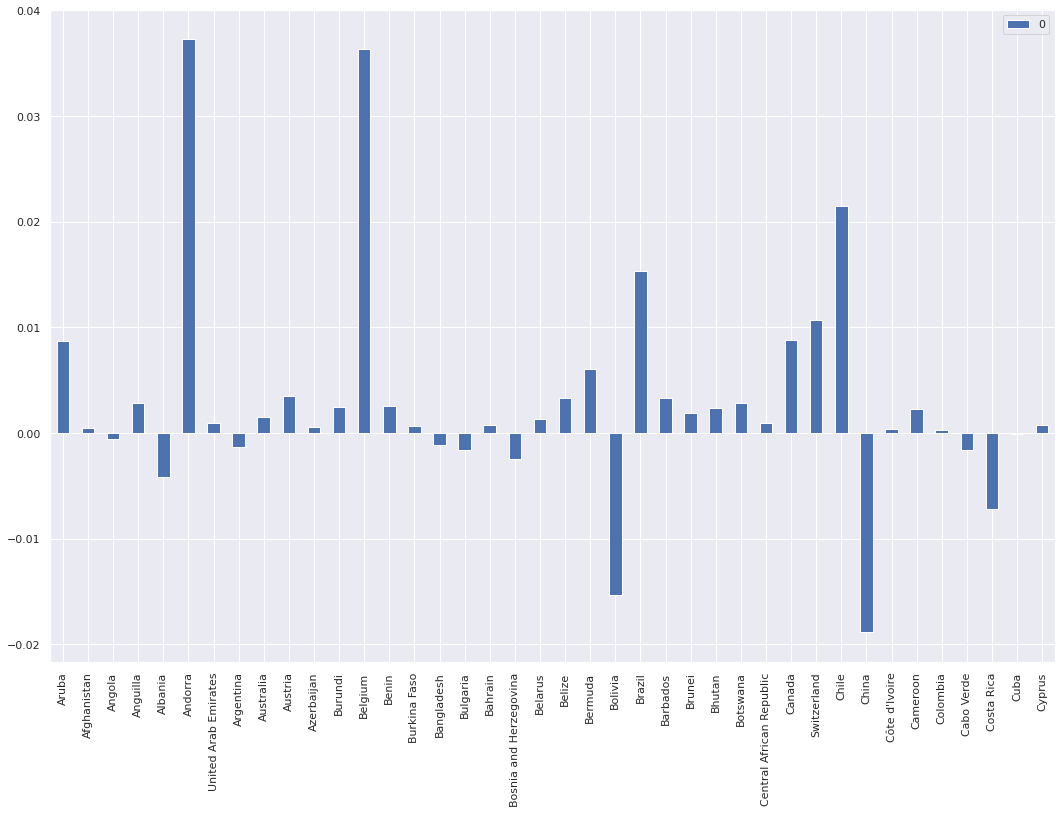

In [36]:
functions.iloc[:40].plot(figsize=(18,12),kind='bar')

<AxesSubplot:>

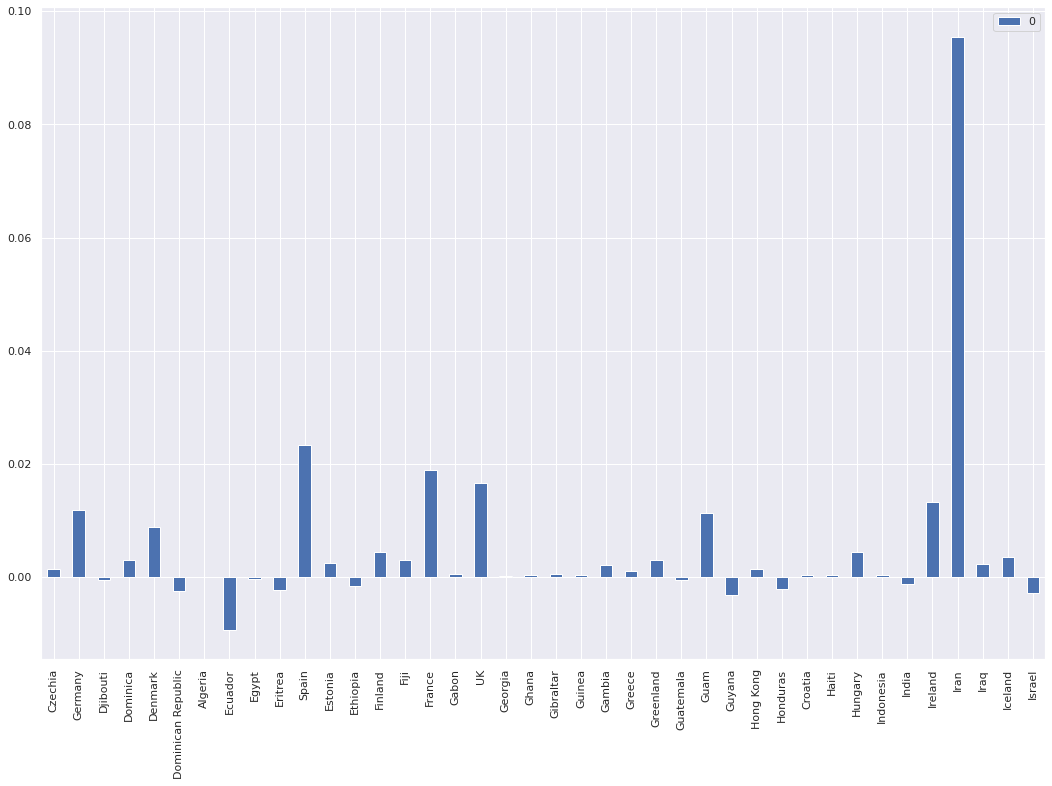

In [37]:
functions.iloc[40:80].plot(figsize=(18,12),kind='bar')

            date  confirmed  dead  oxford_stringency_current country  \
11005 2020-04-18      108.0   1.0                      81.48   Gabon   
11006 2020-04-19      109.0   1.0                      81.48   Gabon   
11007 2020-04-20      109.0   1.0                      81.48   Gabon   
11008 2020-04-21      120.0   1.0                      81.48   Gabon   
11009 2020-04-22      156.0   1.0                      81.48   Gabon   

       oxford_stringency_mean      pop  dead_per_M  abb  country_idx  \
11005               67.208934  2225734     0.44929  GAB           56   
11006               67.208934  2225734     0.44929  GAB           56   
11007               67.208934  2225734     0.44929  GAB           56   
11008               67.208934  2225734     0.44929  GAB           56   
11009               67.208934  2225734     0.44929  GAB           56   

       dead_per_M_std  oxford_curr_std  dead_per_M_std_inc  
11005       -0.398049          0.79531                 0.0  
11006       

confirmed          dead  \
confirmed                  1.000000e+00  9.863876e-01   
dead                       9.863876e-01  1.000000e+00   
oxford_stringency_current -9.064565e-01 -9.449274e-01   
oxford_stringency_mean     8.117885e-16  1.002116e-15   
pop                                 NaN           NaN   
dead_per_M                 9.863876e-01  1.000000e+00   
country_idx                         NaN           NaN   
dead_per_M_std             9.863876e-01  1.000000e+00   
oxford_curr_std           -9.064565e-01 -9.449274e-01   
dead_per_M_std_inc        -1.455203e-01 -1.134598e-01   

                           oxford_stringency_current  oxford_stringency_mean  \
confirmed                              -9.064565e-01            8.117885e-16   
dead                                   -9.449274e-01            1.002116e-15   
oxford_stringency_current               1.000000e+00            7.719420e-16   
oxford_stringency_mean                  7.719420e-16            1.000000e+00   
pop                                              NaN                     NaN   
dead_per_M                             -9.449274e-01           -7.073399e-16   
country_idx                                      NaN                     NaN   
dead_per_M_std                         -9.449274e-01           -7.091144e-15   
oxford_curr_std                         1.000000e+00           -1.388980e-15   
dead_per_M_std_inc                      7.941480e-02            1.260777e-16   

                           pop    dead_per_M  country_idx  dead_per_M_std  \
confirmed                  NaN  9.863876e-01          NaN    9.863876e-01   
dead                       NaN  1.000000e+00          NaN    1.000000e+00   
oxford_stringency_current  NaN -9.449274e-01          NaN   -9.449274e-01   
oxford_stringency_mean     NaN -7.073399e-16          NaN   -7.091144e-15   
pop                        NaN           NaN          NaN             NaN   
dead_per_M                 NaN  1.000000e+00          NaN    1.000000e+00   
country_idx                NaN           NaN          NaN             NaN   
dead_per_M_std             NaN  1.000000e+00          NaN    1.000000e+00   
oxford_curr_std            NaN -9.449274e-01          NaN   -9.449274e-01   
dead_per_M_std_inc         NaN -1.134598e-01          NaN   -1.134598e-01   

                           oxford_curr_std  dead_per_M_std_inc  
confirmed                    -9.064565e-01       -1.455203e-01  
dead                         -9.449274e-01       -1.134598e-01  
oxford_stringency_current     1.000000e+00        7.941480e-02  
oxford_stringency_mean       -1.388980e-15        1.260777e-16  
pop                                    NaN                 NaN  
dead_per_M                   -9.449274e-01       -1.134598e-01  
country_idx                            NaN                 NaN  
dead_per_M_std               -9.449274e-01       -1.134598e-01  
oxford_curr_std               1.000000e+00        7.941480e-02  
dead_per_M_std_inc            7.941480e-02        1.000000e+00

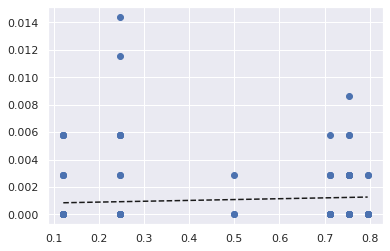

In [38]:
import scipy.stats as sps


gabon = foo.loc[foo['country'] == 'Gabon']
print (gabon.head())

slope,intercept,_,_,_ = sps.linregress(gabon['oxford_curr_std'],gabon['dead_per_M_std_inc'])

print (slope,intercept)

#gabon.plot(x='date',y=['dead_per_M_std_inc','oxford_curr_std'],color=['r','b'])
plt.scatter(gabon['oxford_curr_std'],gabon['dead_per_M_std_inc'])
X = np.linspace(gabon['oxford_curr_std'].min(),gabon['oxford_curr_std'].max(),100)
plt.plot(X,intercept + slope * X,color='k',ls='dashed')
gabon.corr()

<AxesSubplot:>

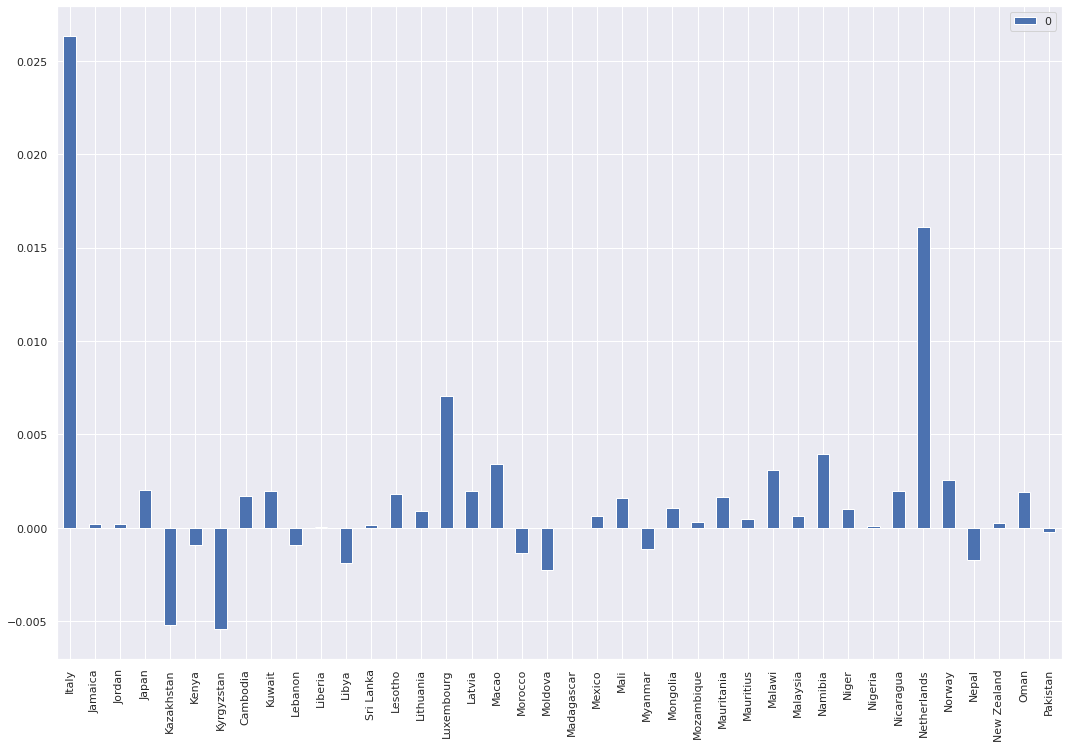

In [39]:
functions.iloc[80:120].plot(figsize=(18,12),kind='bar')

<AxesSubplot:>

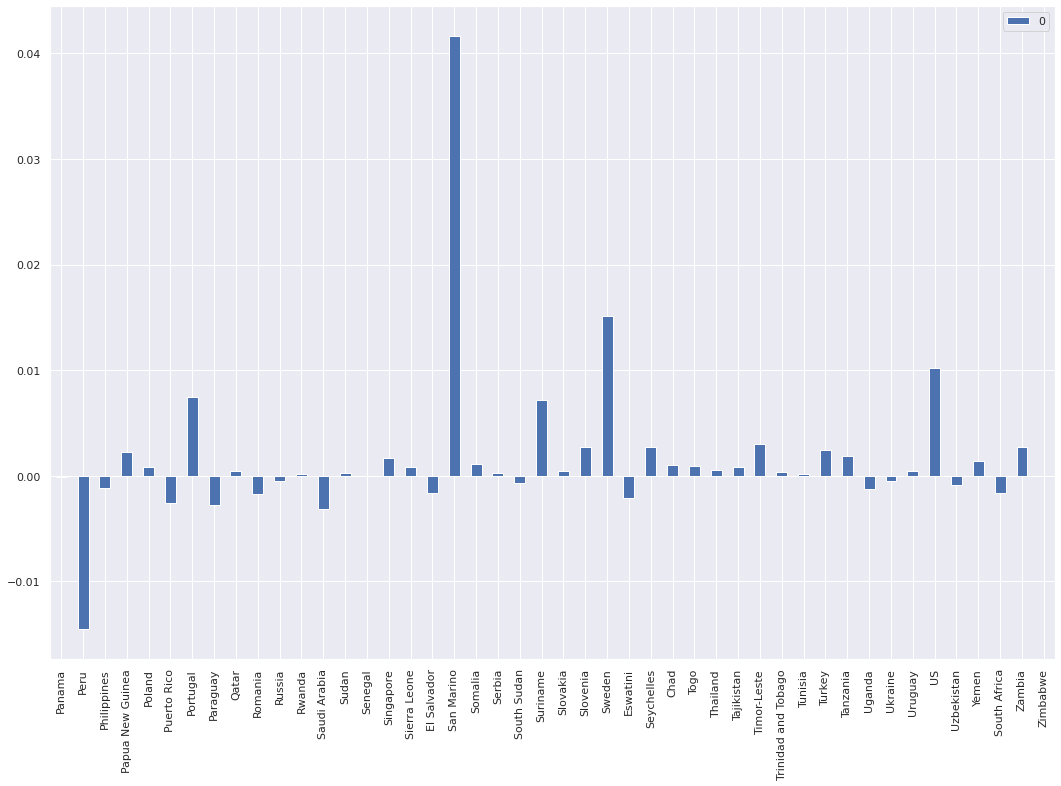

In [40]:
functions.iloc[120:].plot(figsize=(18,12),kind='bar')

-0.06089319787323437 0.10009943403799945


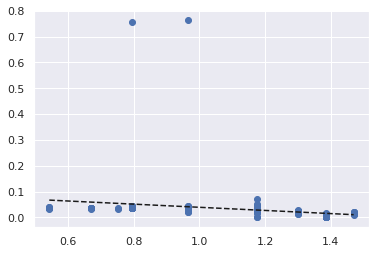

In [41]:
peru = foo.loc[foo['country'] == 'Peru']
plt.scatter(peru['oxford_curr_std'],peru['dead_per_M_std_inc'])
slope,intercept,_,_,_ = sps.linregress(peru['oxford_curr_std'],peru['dead_per_M_std_inc'])
print (slope,intercept)
X = np.linspace(peru['oxford_curr_std'].min(),peru['oxford_curr_std'].max(),100)
plt.plot(X,intercept + slope * X,color='k',ls='dashed')

In [42]:
foo.loc[foo['abb']=='SOM']

date  confirmed  dead  oxford_stringency_current  country  \
27490 2020-04-18      116.0   5.0                      60.19  Somalia   
27491 2020-04-19      135.0   7.0                      60.19  Somalia   
27492 2020-04-20      164.0   7.0                      60.19  Somalia   
27493 2020-04-21      237.0   8.0                      60.19  Somalia   
27494 2020-04-22      286.0   8.0                      60.19  Somalia   
...          ...        ...   ...                        ...      ...   
27631 2020-09-06     3332.0  97.0                      30.56  Somalia   
27632 2020-09-07     3362.0  97.0                      30.56  Somalia   
27633 2020-09-08     3362.0  97.0                      30.56  Somalia   
27634 2020-09-09     3362.0  97.0                      30.56  Somalia   
27635 2020-09-10     3371.0  97.0                      30.56  Somalia   

       oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
27490               39.110155  15893222    0.314600  SOM          139   
27491               39.110155  15893222    0.440439  SOM          139   
27492               39.110155  15893222    0.440439  SOM          139   
27493               39.110155  15893222    0.503359  SOM          139   
27494               39.110155  15893222    0.503359  SOM          139   
...                       ...       ...         ...  ...          ...   
27631               39.110155  15893222    6.103231  SOM          139   
27632               39.110155  15893222    6.103231  SOM          139   
27633               39.110155  15893222    6.103231  SOM          139   
27634               39.110155  15893222    6.103231  SOM          139   
27635               39.110155  15893222    6.103231  SOM          139   

       dead_per_M_std  oxford_curr_std  dead_per_M_std_inc  
27490       -0.398913        -0.173666            0.000000  
27491       -0.398106        -0.173666            0.000807  
27492       -0.398106        -0.173666            0.000000  
27493       -0.397702        -0.173666            0.000404  
27494       -0.397702        -0.173666            0.000000  
...               ...              ...                 ...  
27631       -0.361782        -1.522222            0.000000  
27632       -0.361782        -1.522222            0.000000  
27633       -0.361782        -1.522222            0.000000  
27634       -0.361782        -1.522222            0.000000  
27635       -0.361782        -1.522222            0.000000  

[146 rows x 13 columns]

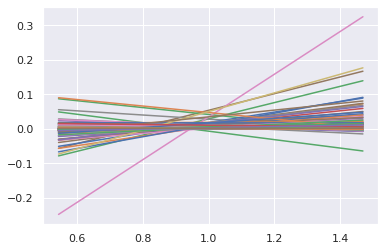

In [43]:
_= [ plt.plot(X,lines[i]) for i in range(len(lines))]

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/plots/traceplot.py:250: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (337), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


                mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta_mean       0.00  0.00      0.00       0.00        0.0      0.0   2041.76   
alpha_mean      0.01  0.00      0.00       0.01        0.0      0.0   1425.00   
alpha[0]        0.01  0.00      0.01       0.02        0.0      0.0   2567.24   
alpha[1]        0.00  0.00     -0.00       0.01        0.0      0.0   1535.30   
alpha[2]        0.00  0.01     -0.01       0.01        0.0      0.0   2083.44   
...              ...   ...       ...        ...        ...      ...       ...   
beta[164]       0.00  0.01     -0.01       0.01        0.0      0.0   1416.06   
beta[165]      -0.00  0.01     -0.01       0.01        0.0      0.0   2133.61   
beta_mean_std   0.01  0.00      0.01       0.01        0.0      0.0    852.26   
alpha_mean_std  0.01  0.00      0.01       0.01        0.0      0.0    767.70   
obs_sigma       0.03  0.00      0.03       0.03        0.0      0.0   1652.29   

                 ess_sd  es

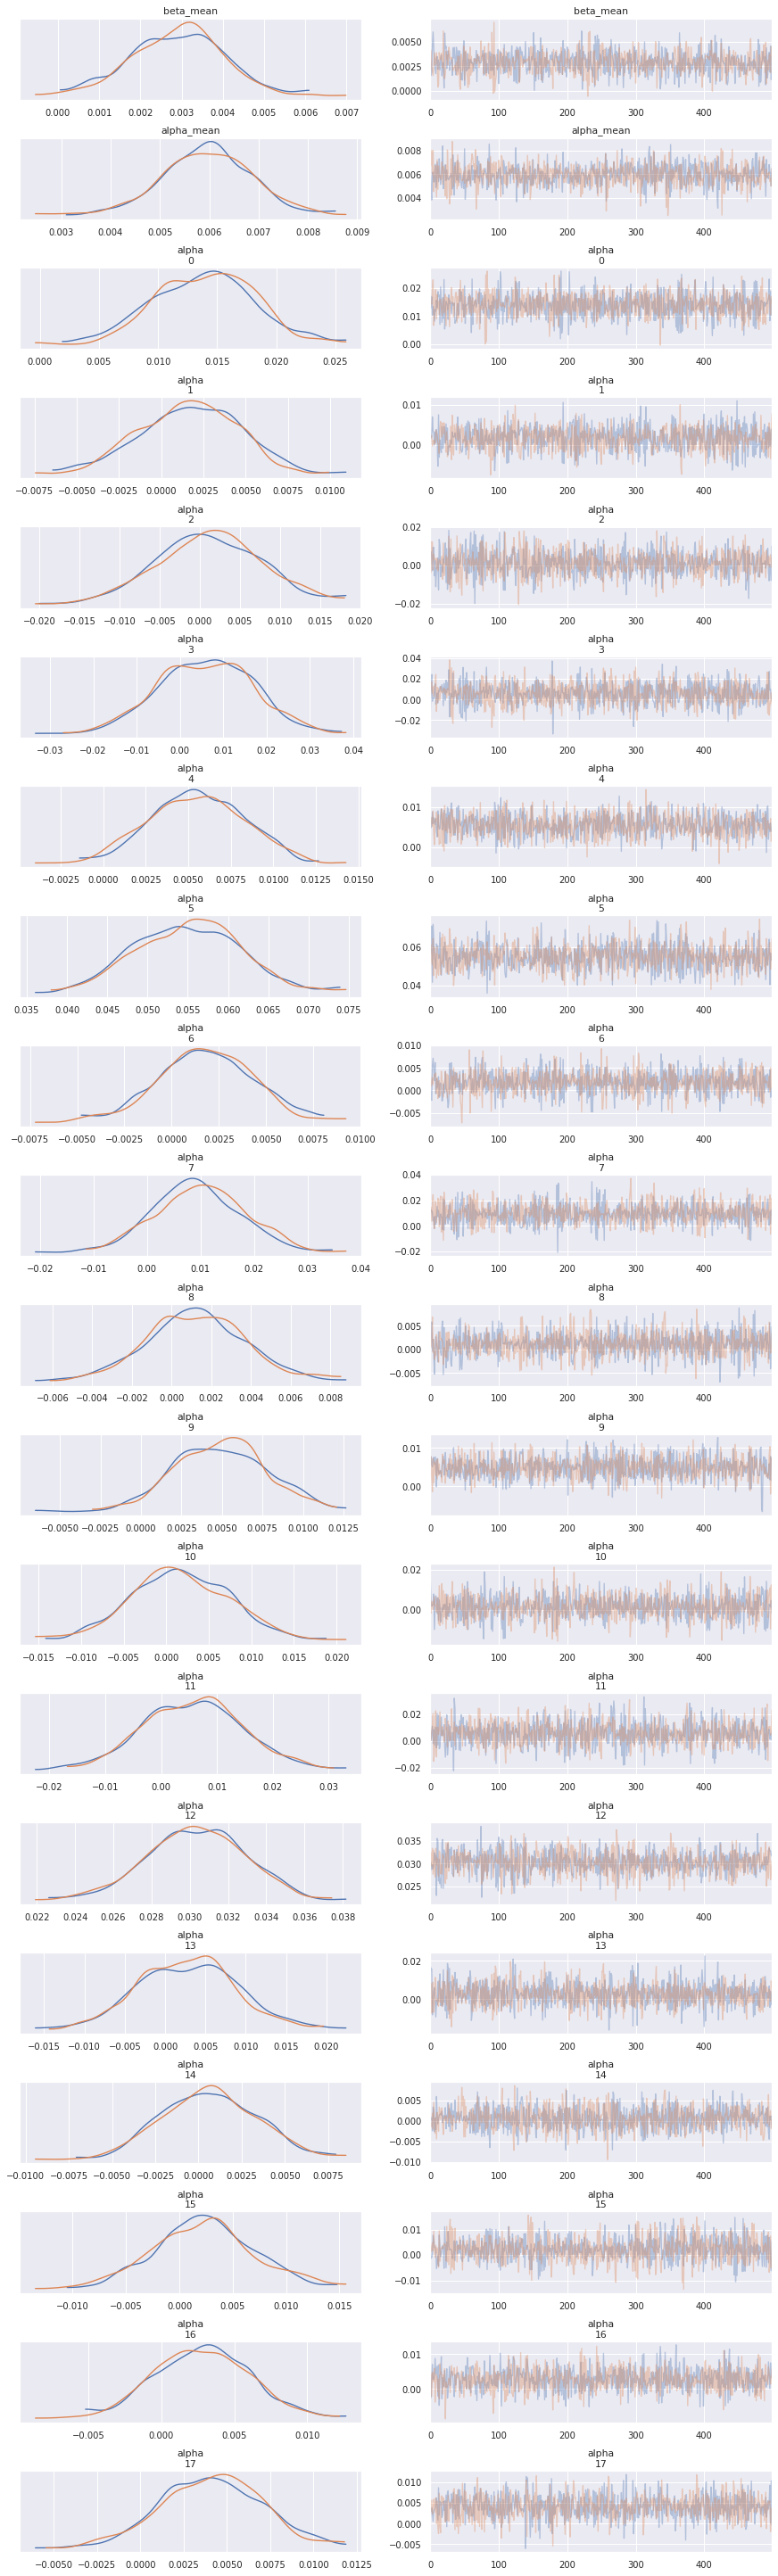

In [44]:
#beta_post = trace['beta'][:]
#alpha_post = trace['alpha'][:]
#obs_sigma_post = trace['obs_sigma'][:]

_= az.plot_trace(trace)
print (az.summary(trace,round_to=2))

#result = pd.DataFrame({'beta_post' : beta_post,
                      #'alpha_post' : alpha_post,
                      #'obs_sigma_post' : obs_sigma_post})

#result.describe()

In [45]:
beta_ci = np.percentile(result['beta_mean'],[5.5,94.5])
alpha_ci = np.percentile(result['alpha_mean'],[5.5,94.5])


In [46]:
result.describe()

beta_mean   alpha_mean     alpha__0     alpha__1     alpha__2  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.002894     0.005938     0.013891     0.001646     0.001179   
std       0.001124     0.000918     0.004264     0.002931     0.006539   
min      -0.000547     0.002475    -0.000384    -0.007456    -0.020477   
25%       0.002117     0.005341     0.010868    -0.000283    -0.003161   
50%       0.002947     0.005964     0.013996     0.001746     0.001050   
75%       0.003626     0.006526     0.016808     0.003713     0.005614   
max       0.006986     0.008770     0.025904     0.010941     0.018205   

          alpha__3     alpha__4     alpha__5     alpha__6     alpha__7  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.005758     0.005494     0.055039     0.001778     0.009607  ...   
std       0.010789     0.002712     0.006494     0.002515     0.008153  ...   
min      -0.033363    -0.003989     0.036081    -0.007212    -0.020864  ...   
25%      -0.001959     0.003608     0.050387     0.000131     0.004149  ...   
50%       0.006097     0.005481     0.054993     0.001794     0.009443  ...   
75%       0.013507     0.007374     0.059481     0.003455     0.014942  ...   
max       0.038287     0.014267     0.074630     0.009226     0.037185  ...   

         beta__159    beta__160    beta__161    beta__162    beta__163  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.000442     0.010199    -0.000874     0.001438    -0.001642   
std       0.003376     0.004271     0.004856     0.004277     0.006252   
min      -0.010244    -0.004637    -0.015704    -0.015745    -0.020955   
25%      -0.001846     0.007254    -0.004065    -0.001291    -0.006289   
50%       0.000387     0.010243    -0.000852     0.001366    -0.001541   
75%       0.002807     0.013182     0.002329     0.004068     0.002902   
max       0.011413     0.026110     0.012406     0.017487     0.022811   

         beta__164    beta__165  beta_mean_std  alpha_mean_std    obs_sigma  
count  1000.000000  1000.000000    1000.000000     1000.000000  1000.000000  
mean      0.002690    -0.000058       0.011943        0.010411     0.034694  
std       0.006536     0.008133       0.000857        0.000825     0.000146  
min      -0.014545    -0.025011       0.009163        0.007838     0.034221  
25%      -0.001829    -0.005558       0.011370        0.009857     0.034595  
50%       0.002789    -0.000445       0.011868        0.010419     0.034696  
75%       0.007415     0.005934       0.012459        0.010923     0.034787  
max       0.026189     0.027095       0.015726        0.013449     0.035175  

[8 rows x 337 columns]

In [47]:

X = np.linspace(-3,3,5)
mean_req = np.array([X[i] * result['beta_mean'].mean() + result['alpha_mean'].mean() for i in range(len(X))])

slope,intercept,_,_,_ = sps.linregress(foo['oxford_curr_std'],foo['dead_per_M_std_inc'])

least_squares = np.array([X[i] * slope + intercept for i in range(len(X))])

In [48]:
rows = np.random.choice(result.index,replace=True,size=len(X))
beta_samples = result['beta_mean'][rows]
alpha_samples = result['alpha_mean'][rows]

lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])


samples = np.array([pm.Normal.dist(X[i] * result.beta_mean[rows] + result.alpha_mean[rows],
                                      result.obs_sigma[rows]).random(size=len(X)) for i in range(len(X))])

high,low = np.percentile(samples,[5.5,94.5],axis=1)


lines

array([[ 0.00024973, -0.01035037,  0.00048054, -0.01007789, -0.00092862],
       [ 0.00306439, -0.00266646,  0.00332439, -0.00251595,  0.00271141],
       [ 0.00587906,  0.00501745,  0.00616823,  0.00504599,  0.00635143],
       [ 0.00869372,  0.01270136,  0.00901208,  0.01260794,  0.00999145],
       [ 0.01150839,  0.02038527,  0.01185593,  0.02016988,  0.01363147]])

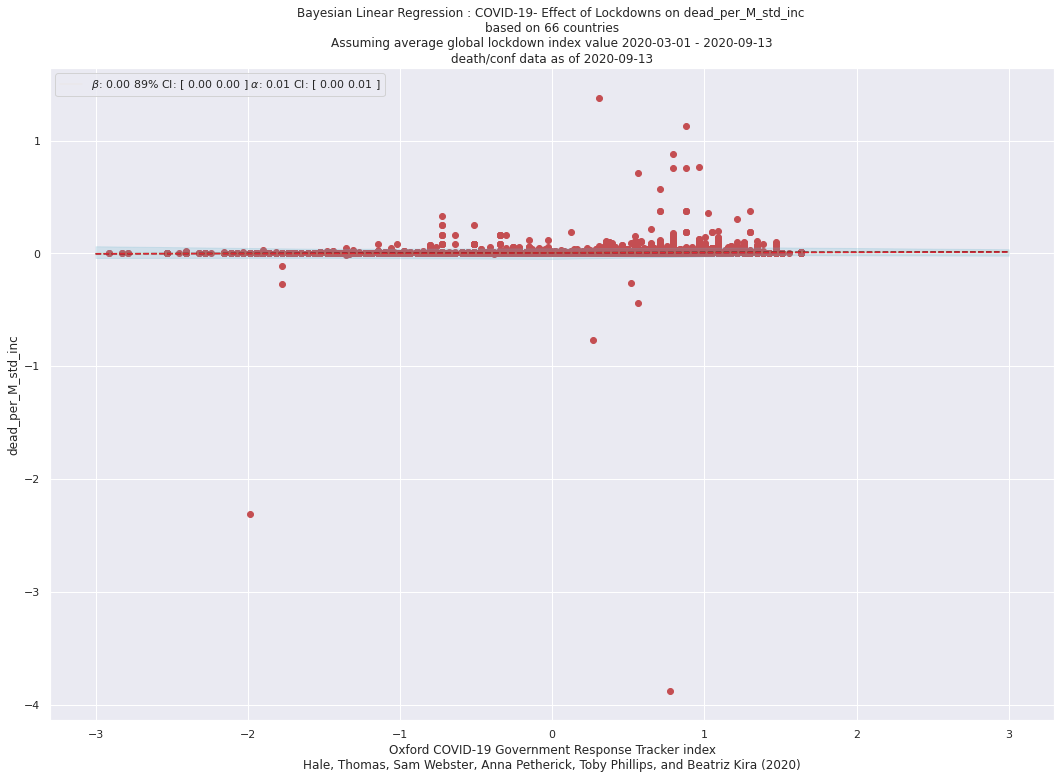

In [49]:
plt.figure(figsize=(18,12))
plt.title('Bayesian Linear Regression : COVID-19'\
          '- Effect of Lockdowns on {} \n'.format(y_param)+\
          'based on {} countries\n'.format(len(last_days))+\
          'Assuming average global lockdown index value {} - {}\n'.format(start_date,end_date)+\
         'death/conf data as of {}'.format(end_date))

plt.scatter(foo['oxford_curr_std'],foo['dead_per_M_std_inc'],color='r')
plt.ylabel(y_param)
plt.xlabel('Oxford COVID-19 Government Response Tracker index\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020)')

plt.plot(X,mean_req,ls='dashed',color='k')
plt.plot(X,least_squares,ls='dashed',color='crimson')

plt.fill_between(X,high,low,color='c',alpha=0.2)

countries_of_interest = ['SWE','GBR','BEL','ESP','ITA','PER','FRA',
                         'USA','DNK','FIN','NOR','BRA','CHL','QAT','BHR',
                        'HNT','GTM','NIC','JPN','ISL','ARG','NLD','DEU','ZAF','HND','IRQ']

#for i,p in enumerate(foo['oxford_curr_std']):
    #if last_days.iloc[i]['abb'] in countries_of_interest:
    #plt.text(foo.iloc[i]['oxford_curr_std'],foo.iloc[i]['dead_per_M_std_inc'],foo.iloc[i]['abb'])

plt.plot(X,lines[0,:],
         color='orange',
         alpha=0.03,
         label=r'$\beta$: {:.2f} 89% CI: [ {:.2f} {:.2f} ] $\alpha$: {:.2f} CI: [ {:.2f} {:.2f} ]'.format(
         result.beta_mean.mean(),beta_ci[0],beta_ci[1],result.alpha_mean.mean(),alpha_ci[0],alpha_ci[1]))

_=plt.plot(X,lines,color='orange',alpha=0.03)

plt.legend(loc='upper left')

plt.savefig('lockdown_index_{}.jpg'.format(y_param),format='jpg',dpi=400)

In [50]:
foo.dropna(inplace=True)

<ipython-input-50-c0916f8ba34f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foo.dropna(inplace=True)


In [51]:
countries = foo.groupby('country')
some_countries = ['Sweden','Belgium','UK','South Africa','Germany','US',
                  'Denmark','Australia','Italy','France','Argentina','Brazil','Chile','Peru']

colors = ['black','grey','lightcoral','mistyrose','tan','gold','crimson','yellow',
         'deepskyblue','royalblue','orangered','lime','aqua','darkmagenta']



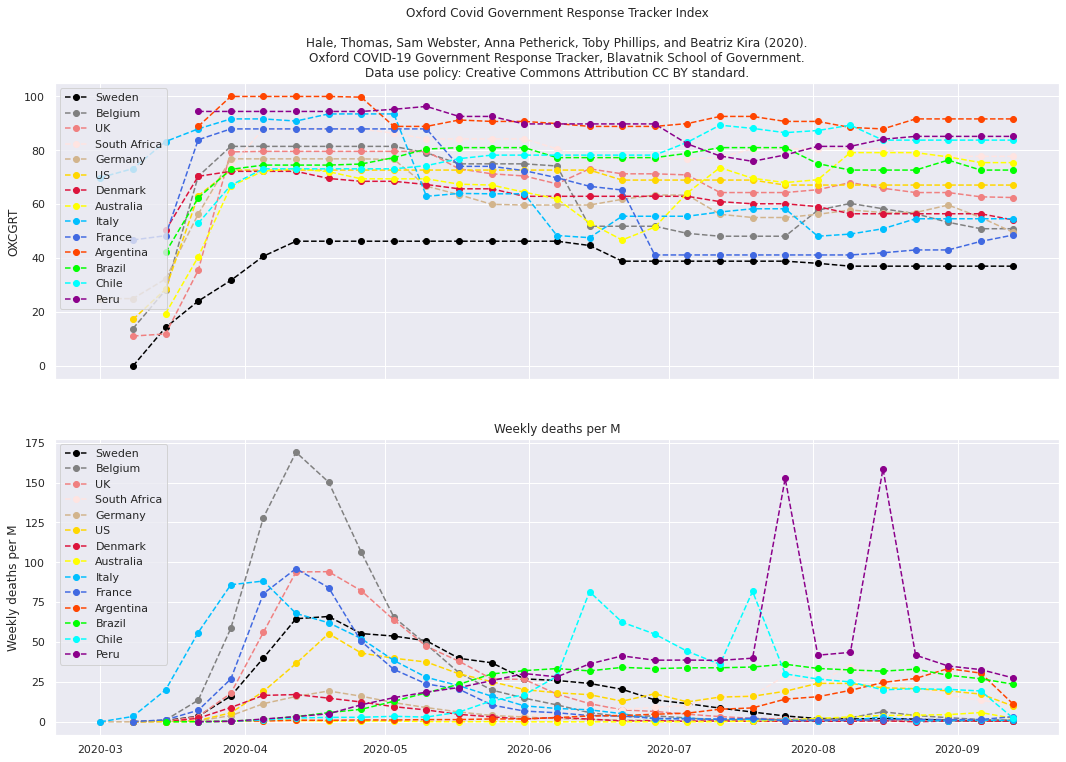

In [52]:
from datetime import datetime

weeklies = dict()

fig,ax = plt.subplots(2,1,sharex=True,figsize=(18,12))


for i,c in enumerate(some_countries):
    country = (countries.get_group(c)).copy()
    country.set_index('date',inplace=True)
    country['dead_inc'] = country['dead'] - country['dead'].shift()
    country['dead_inc_per_M'] = country['dead_inc'] / (country['pop'] / 1e6)
    
    resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
    
    #today = datetime.today().weekday()
    last_data_day = last_data_date.weekday()

    #yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]
    period = resample_period[last_data_day]
    
    weekly = country.resample(period).agg({'dead_inc_per_M' : np.sum, 'dead_per_M' :np.sum,
                                           'oxford_stringency_current' : np.mean})
    
    weeklies[c] = weekly
        
    ax[1].plot(weekly.index,weekly['dead_inc_per_M'],'o--',label=c,color=colors[i])
    ax[0].plot(weekly.index,weekly['oxford_stringency_current'],'o--',label=c,color=colors[i])
 
citation = '\nHale, Thomas, Sam Webster, Anna Petherick, Toby Phillips, and Beatriz Kira (2020).\nOxford COVID-19 Government Response Tracker, Blavatnik School of Government.\nData use policy: Creative Commons Attribution CC BY standard.'
ax[0].legend(loc='upper left')
ax[0].set_title('Oxford Covid Government Response Tracker Index\n' + citation)
ax[0].set_ylabel('OXCGRT')
#ax[0].set_yscale('log')
ax[1].legend(loc='upper left')
ax[1].set_title('Weekly deaths per M')
ax[1].set_ylabel('Weekly deaths per M')
#ax[1].set_yscale('log')
plt.savefig('oxcgrt_country_plot.jpg',format='jpg',dpi=400)

In [53]:

def inference(x,y):
    
    beta_mean = 0
    beta_std = 10
    alpha_low = -500
    alpha_high = 500
    obs_sigma_high = 1000
    
    model = pm.Model()
    
    with model:

        alpha = pm.Uniform('alpha',alpha_low,alpha_high)
        beta = pm.Normal('beta',mu=beta_mean,sd=beta_std)
        obs_sigma = pm.Uniform('obs_sigma',0,obs_sigma_high)

        linreq = alpha + x.values * beta

        obs = pm.Normal('obs',mu = linreq,tau = 1 / obs_sigma ** 2,observed = y)

        trace = pm.sample(1000,tune=1000)   

        beta_post = trace['beta'][:]
        alpha_post = trace['alpha'][:]
        obs_sigma_post = trace['obs_sigma'][:]

        result = pd.DataFrame({'beta_post' : beta_post,
                              'alpha_post' : alpha_post,
                              'obs_sigma_post' : obs_sigma_post})
        _= az.plot_trace(trace)
        print (az.summary(trace,round_to=2))
        
        

        return result


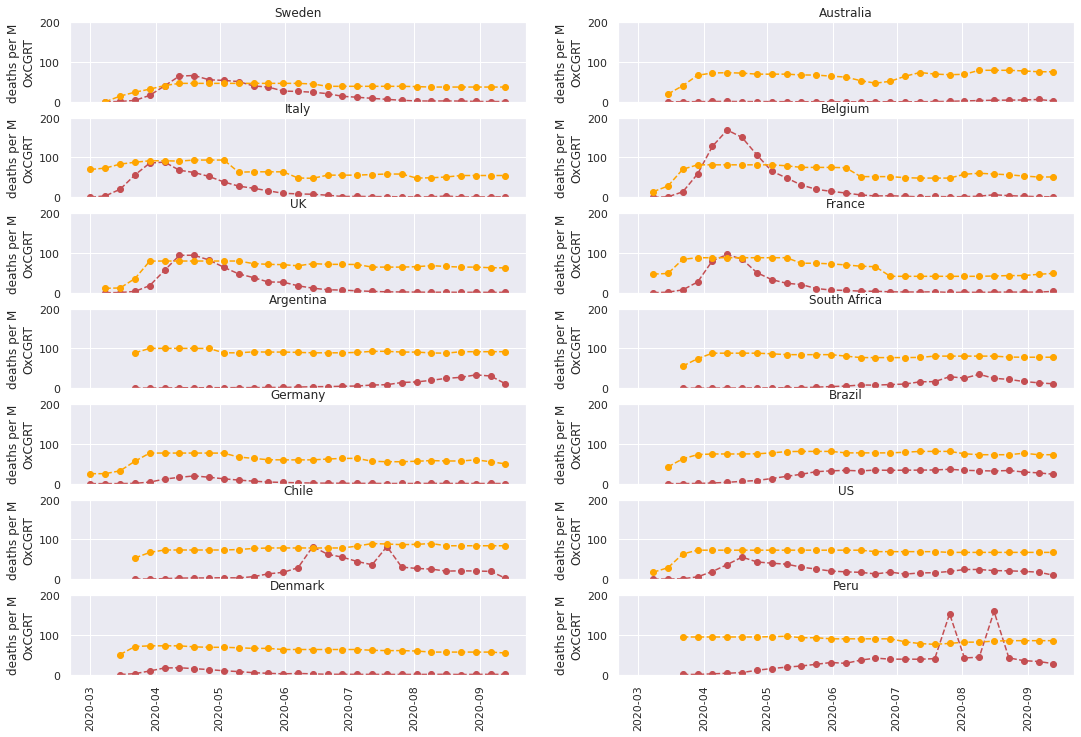

In [54]:
import scipy.stats as sps

weeklies_df = pd.DataFrame()


fig,axes = plt.subplots(7,2,sharex=True,figsize=(18,12))

for i,k in enumerate(weeklies.keys()):
        
    weeklies[k]['country'] = k
        
    weeklies_df = pd.concat([weeklies_df,weeklies[k]])
    
    
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['dead_inc_per_M'],'o--',label='weekly deaths per M',
                           color='r')
    axes[i % 7,i % 2].plot(weeklies[k].index,weeklies[k]['oxford_stringency_current'],'o--',label='weekly deaths per M',
                           color='orange')
    axes[i % 7,i % 2].tick_params('x',rotation=90)
    axes[i % 7,i % 2].set_title('{}'.format(k))
    axes[i % 7, i % 2].set_ylabel('deaths per M\nOxCGRT')
    axes[i % 7, i % 2].set_ylim([0,200])
    #axes[i % 7, i % 2].set_yscale('log')
    
plt.savefig('oxcgrt_14.jpg',format='jpg',dpi=400)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.20   0.37      0.62       1.78       0.02     0.01    554.82   
alpha     -24.85  14.41    -48.79      -3.22       0.60     0.46    568.75   
obs_sigma  18.83   2.87     14.24      22.94       0.12     0.09    558.38   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       496.32    554.12    675.55    1.0  
alpha      499.57    572.38    611.53    1.0  
obs_sigma  558.38    470.94    212.75    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.86   0.43      1.14       2.51       0.02     0.01    786.39   
alpha     -83.55  27.39   -124.37     -36.88       0.98     0.69    787.69   
obs_sigma  39.37   5.94     30.68      48.05       0.23     0.16    686.93   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       786.39    790.62    725.18    1.0  
alpha      787.69    789.77    706.39    1.0  
obs_sigma  676.78    695.15    561.72    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.84   0.31      0.34       1.30       0.01     0.01    593.19   
alpha     -32.98  20.53    -63.44       1.51       0.83     0.59    606.88   
obs_sigma  27.74   4.16     21.55      34.26       0.15     0.10    793.48   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       563.93    597.37    843.59   1.00  
alpha      606.88    612.55    849.27   1.00  
obs_sigma  789.10    793.90    842.08   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 23 seconds.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6015737432187941, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta       -0.24   0.31     -0.67       0.27       0.03     0.02     92.02   
alpha      29.22  24.88    -12.06      63.76       2.56     1.82     94.28   
obs_sigma  10.59   1.76      8.29      13.13       0.34     0.24     27.23   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta        92.02    103.71    585.32   1.03  
alpha       94.28    102.82    573.56   1.03  
obs_sigma   27.23     22.90     96.86   1.06  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


            mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.28  0.06      0.18       0.38       0.00     0.00    601.58   
alpha     -12.74  3.94    -18.99      -6.34       0.16     0.11    631.06   
obs_sigma   4.47  0.66      3.45       5.46       0.02     0.02    793.43   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       601.58    598.14    696.94    1.0  
alpha      631.06    627.97    629.33    1.0  
obs_sigma  793.43    725.21    649.38    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.56   0.18      0.30       0.87       0.01     0.01    569.90   
alpha     -16.89  12.34    -36.16       2.79       0.51     0.37    577.73   
obs_sigma  11.80   1.74      9.20      14.51       0.08     0.05    524.38   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       552.05    573.83    648.89    1.0  
alpha      544.27    583.93    650.41    1.0  
obs_sigma  524.38    472.08    242.72    1.0  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8809139966961149, but should be close to 0.8. Try to increase the number of tuning steps.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.72  0.12      0.53       0.92       0.01     0.00    363.46   
alpha     -41.40  7.66    -53.55     -29.02       0.40     0.29    359.15   
obs_sigma   3.61  0.55      2.70       4.38       0.03     0.02    256.18   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       346.43    369.03    450.13   1.01  
alpha      342.79    365.06    468.89   1.01  
obs_sigma  256.18    202.12     95.25   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7177352746658807, but should be close to 0.8. Try to increase the number of tuning steps.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6584339346261996, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


           mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta       0.06  0.02      0.03       0.10       0.00     0.00    377.23   
alpha     -3.08  1.52     -5.41      -0.62       0.08     0.05    403.42   
obs_sigma  1.52  0.24      1.15       1.83       0.02     0.01    158.49   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       377.23    374.82    374.31   1.00  
alpha      403.42    392.71    349.78   1.00  
obs_sigma  158.49    110.19    110.28   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6797415735489576, but should be close to 0.8. Try to increase the number of tuning steps.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.45   0.18      1.19       1.75       0.01     0.01    509.02   
alpha     -75.84  12.10    -96.15     -57.86       0.54     0.38    503.79   
obs_sigma  14.93   2.31     11.53      18.65       0.20     0.14    130.18   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       509.02    507.79    724.86   1.00  
alpha      503.79    503.75    574.76   1.01  
obs_sigma  130.18    120.55     37.27   1.03  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.01   0.20      0.68       1.30       0.01     0.01    711.71   
alpha     -45.39  12.85    -64.31     -24.12       0.50     0.36    673.01   
obs_sigma  20.28   3.06     15.41      24.52       0.14     0.10    498.57   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       682.51    720.05    711.44   1.00  
alpha      631.03    671.92    801.66   1.00  
obs_sigma  490.25    469.61    348.30   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta       -0.74   0.52     -1.63       0.03       0.03     0.02    420.27   
alpha      76.63  48.22      3.65     157.16       2.34     1.65    425.68   
obs_sigma  10.59   1.68      7.80      12.87       0.11     0.08    224.11   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       420.27    418.36    581.50   1.01  
alpha      425.68    424.95    558.48   1.01  
obs_sigma  224.11    180.28     74.63   1.01  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6742723973923062, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        0.92   0.32      0.42       1.40       0.02     0.01    266.72   
alpha     -46.19  23.99    -83.96     -10.39       1.47     1.04    266.29   
obs_sigma  11.99   1.78      9.69      14.97       0.10     0.07    339.99   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       266.72    263.93    504.13   1.02  
alpha      266.29    263.48    502.73   1.02  
obs_sigma  339.99    249.44    212.68   1.00  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7198554289058604, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


            mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        1.41   0.61      0.46       2.41       0.03     0.02    554.10   
alpha     -87.84  48.51   -171.72     -15.47       2.06     1.52    555.70   
obs_sigma  22.92   3.70     17.42      28.19       0.35     0.25    109.99   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta       516.23    545.41    500.00   1.01  
alpha      507.25    546.78    442.20   1.01  
obs_sigma  109.99     78.48     50.51   1.02  


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6852810956232395, but should be close to 0.8. Try to increase the number of tuning steps.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6497539189531005, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


             mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean  \
beta        -3.87   0.74     -4.78      -2.44       0.23     0.17     10.04   
alpha      377.30  66.16    265.47     475.28      21.02    15.33      9.90   
obs_sigma   34.51   4.66     26.32      40.89       0.34     0.24    192.07   

           ess_sd  ess_bulk  ess_tail  r_hat  
beta        10.04     11.48     19.83   1.14  
alpha        9.90     11.80     16.12   1.13  
obs_sigma  192.07    155.85    265.60   1.05  


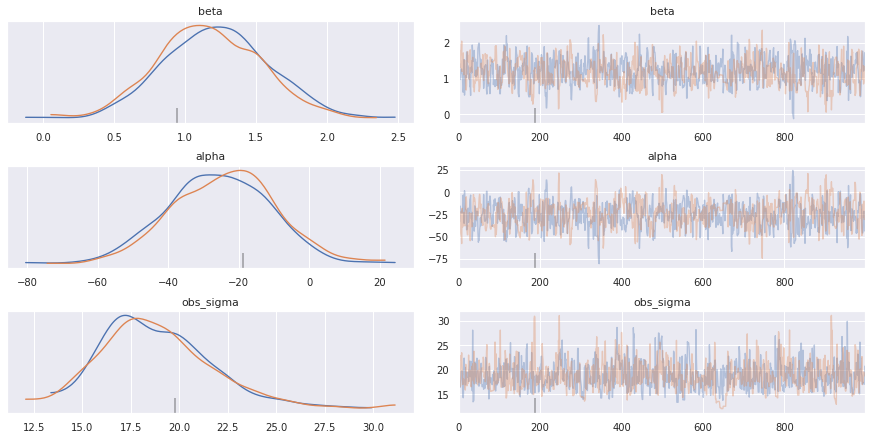

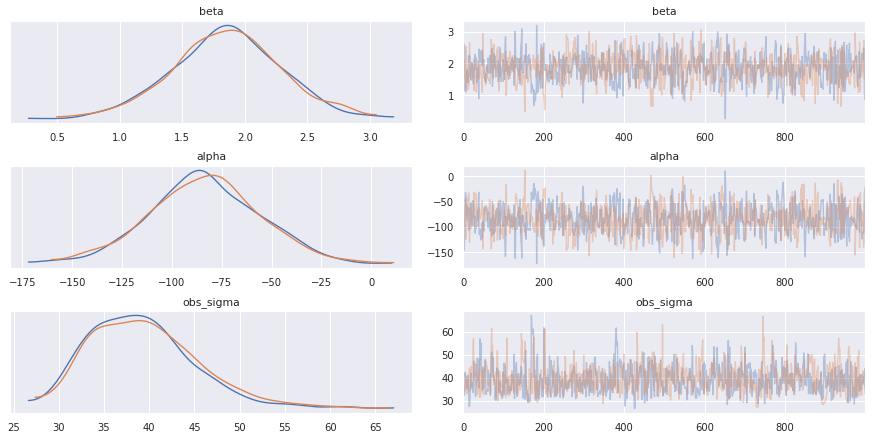

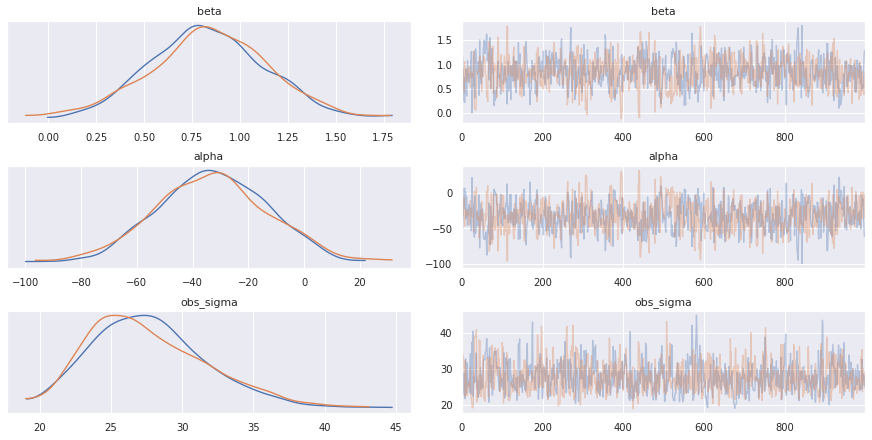

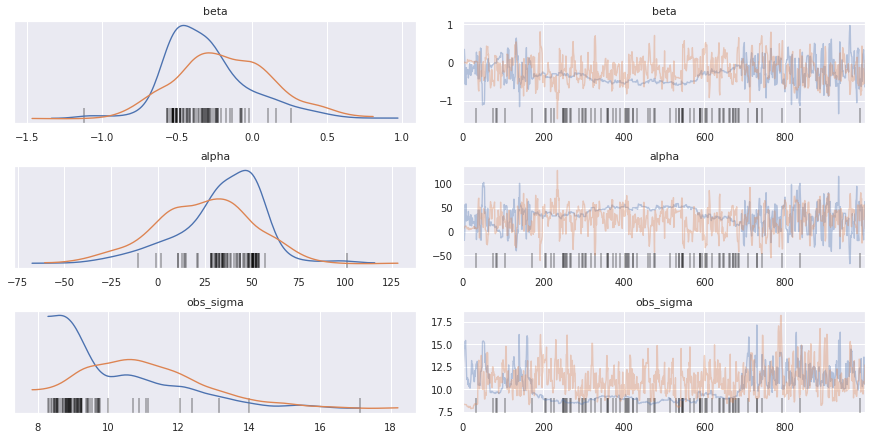

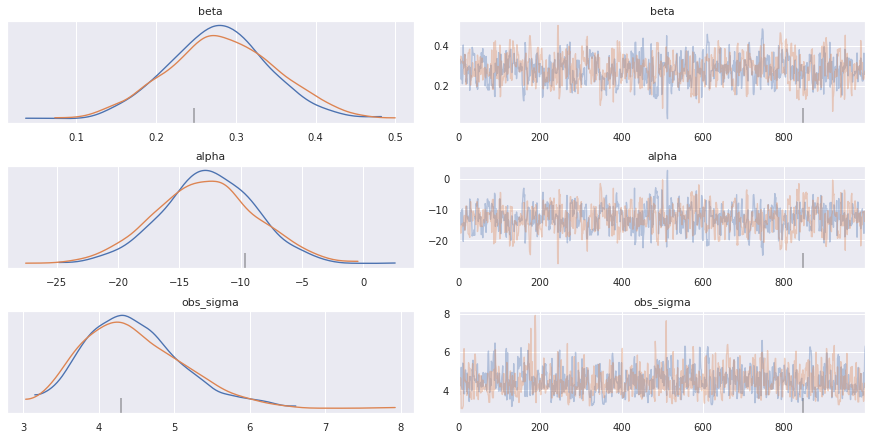

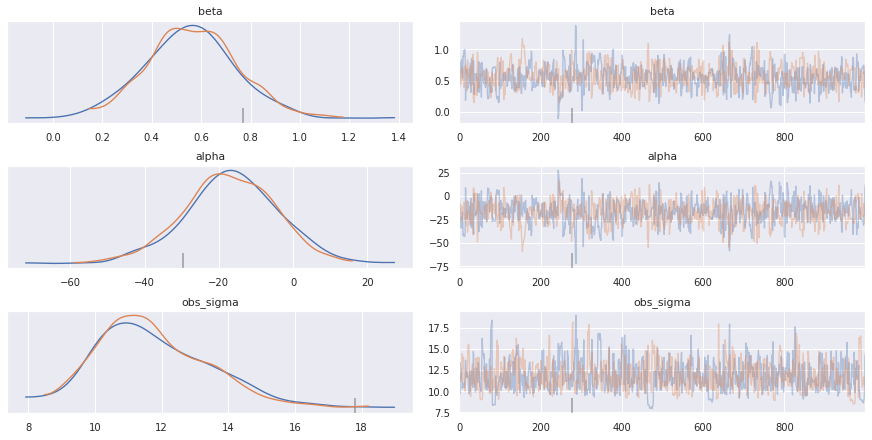

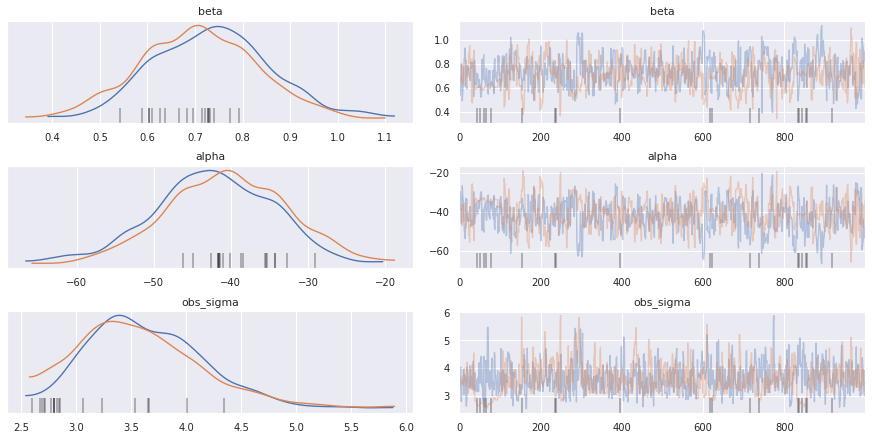

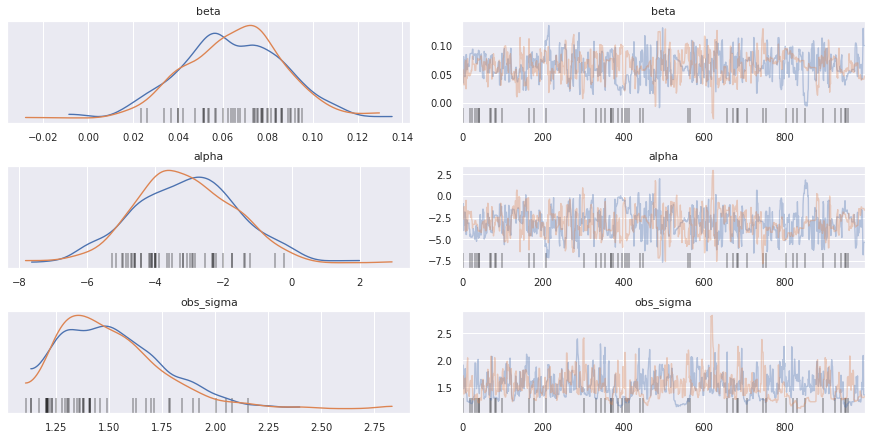

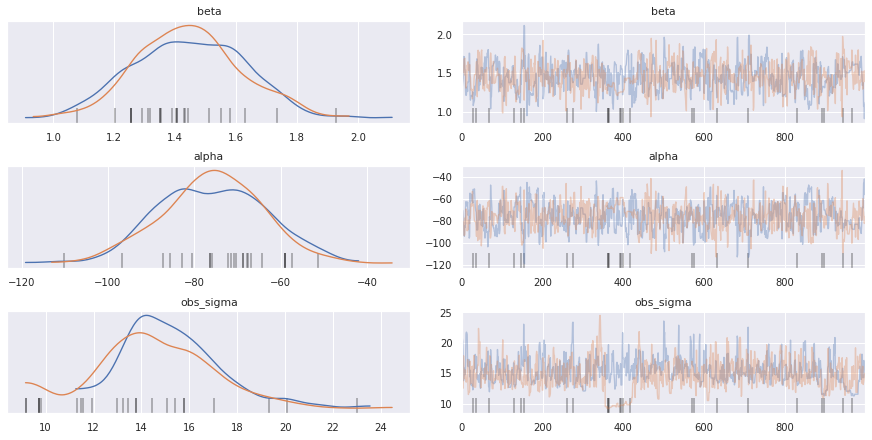

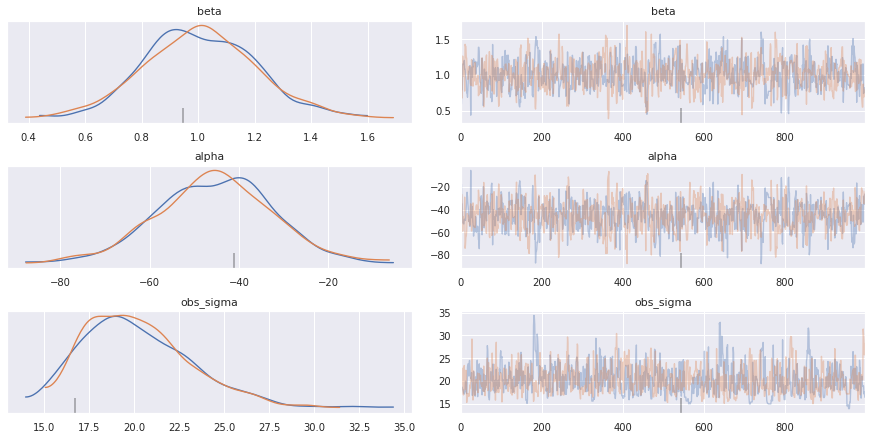

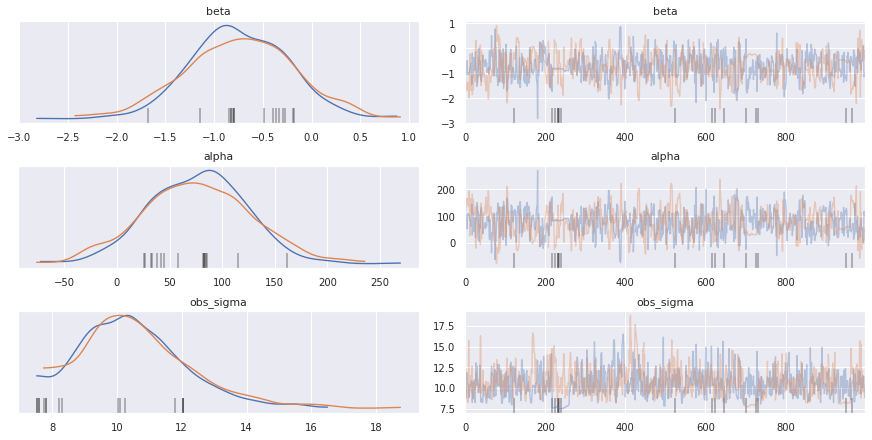

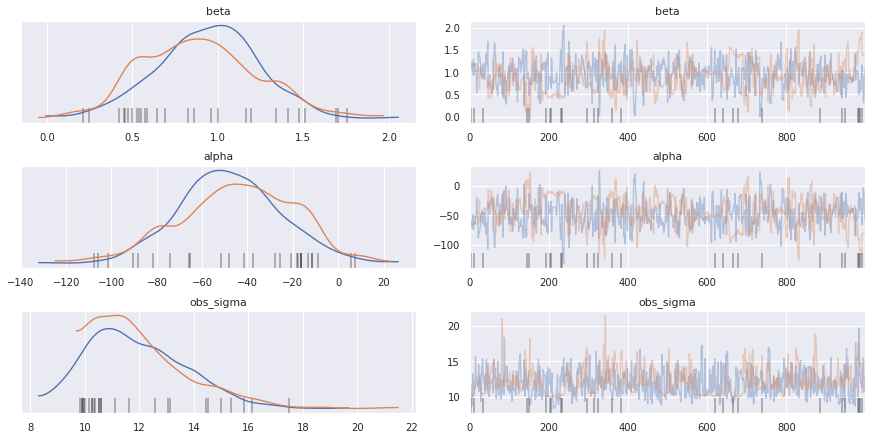

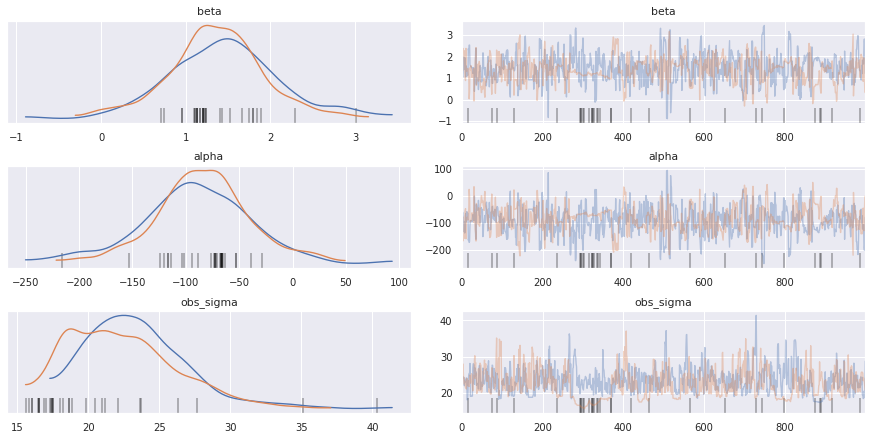

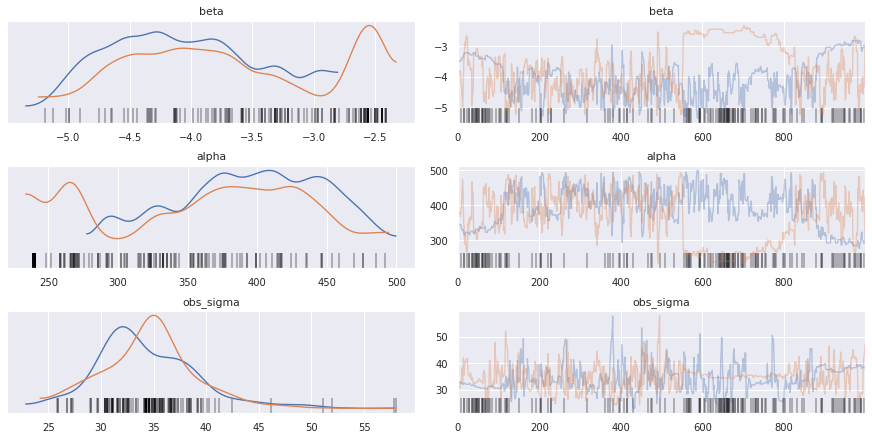

In [55]:
results = dict()

for i,k in enumerate(weeklies.keys()):

    results[k] = inference(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'])



In [56]:


print (results['Argentina'].describe())
results['Sweden'].describe()


         beta_post   alpha_post  obs_sigma_post
count  2000.000000  2000.000000     2000.000000
mean     -0.738249    76.633392       10.588683
std       0.522358    48.215533        1.683551
min      -2.821399   -76.387280        7.525884
25%      -1.095820    43.085269        9.427950
50%      -0.748034    77.874042       10.379764
75%      -0.373002   109.544468       11.496454
max       0.910343   269.636050       18.743197


beta_post   alpha_post  obs_sigma_post
count  2000.000000  2000.000000     2000.000000
mean      1.195022   -24.854482       18.833539
std       0.365853    14.406023        2.873846
min      -0.120533   -80.431230       12.068308
25%       0.944147   -34.676393       16.858148
50%       1.188147   -24.526795       18.493038
75%       1.445876   -14.732369       20.489195
max       2.476240    24.417123       31.131226

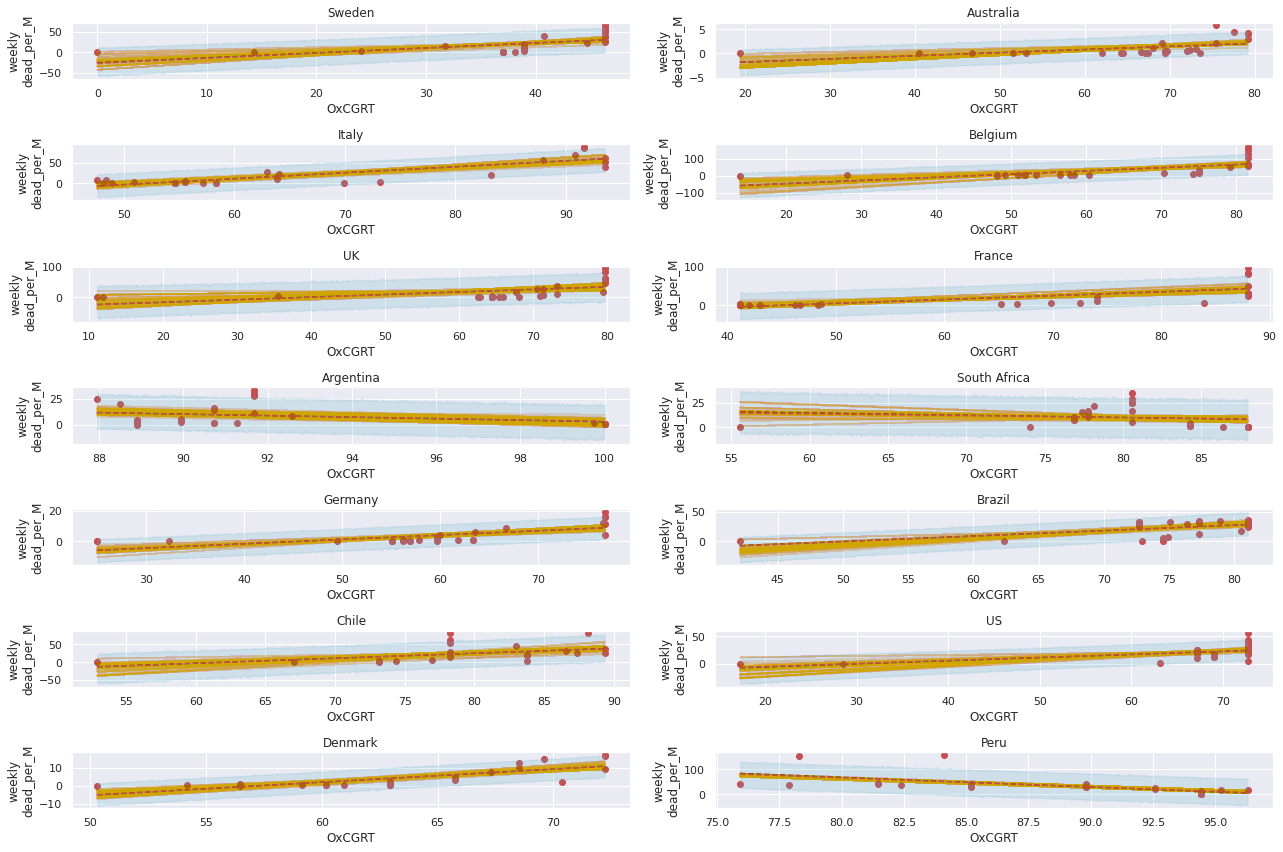

In [57]:
fig,axes = plt.subplots(7,2,figsize=(18,12))

nr_samples = 1000

for i,k in enumerate(weeklies.keys()):

    axes[i % 7,i %2].scatter(weeklies[k]['oxford_stringency_current'],weeklies[k]['dead_inc_per_M'],color='r')

    slope,intercept,_,_,_ = sps.linregress(weeklies[k]['oxford_stringency_current'],
                                           weeklies[k]['dead_inc_per_M'])

    X = np.linspace(weeklies[k]['oxford_stringency_current'].min(),
                    weeklies[k]['oxford_stringency_current'].max(),nr_samples)
        
    #X = np.linspace(0,100,nr_samples) # for computing samples, this must concur with nr of sample rows
    
    alpha_mean = results[k].alpha_post.mean()
    beta_mean = results[k].beta_post.mean()
    
    axes[i % 7, i %2].plot(X,X*beta_mean + alpha_mean,'--',color='k')
    
    rows = np.random.choice(range(len(weeklies[k].index)),replace=True,size=nr_samples)
    
    lines = [X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post for i in range(len(X))]
    
    samples = np.array([pm.Normal.dist(X[i] * results[k].iloc[rows].beta_post + results[k].iloc[rows].alpha_post,
                                      results[k].iloc[rows].obs_sigma_post).random(size=len(X)) for i in range(len(X))])

    high,low = np.percentile(samples,[5.5,94.5],axis=1)
    
    axes[i % 7, i % 2].plot(X,lines,color='orange',alpha=0.01)
    
    least_squares = X * slope + intercept

    axes[i % 7, i % 2].plot(X,least_squares,'--',color='r')
    
    axes[i % 7, i % 2].fill_between(X,high,low,color='c',alpha=0.2)

    
    axes[i % 7, i % 2].set_title(k)
    axes[i % 7, i % 2].set_ylabel('weekly\ndead_per_M')
    axes[i % 7, i % 2].set_xlabel('OxCGRT')
    #axes[i % 7,i % 2].set_ylim([0,150])
    
plt.tight_layout()
plt.savefig('OxCGRT_regression_14.jpg',format='jpg',dpi=400)

In [58]:
swe_weekly = weeklies_df.loc[weeklies_df['country'] == 'Sweden']
bel_weekly = weeklies_df.loc[weeklies_df['country'] == 'Belgium']
arg_weekly = weeklies_df.loc[weeklies_df['country'] == 'Argentina']

In [59]:
swe_weekly

dead_inc_per_M   dead_per_M  oxford_stringency_current country
date                                                                      
2020-03-08        0.000000     0.000000                   0.000000  Sweden
2020-03-15        0.792137     2.673462                  14.287143  Sweden
2020-03-22        3.465599    15.644703                  24.072857  Sweden
2020-03-29       16.139788    82.085181                  31.747143  Sweden
2020-04-05       40.002911   284.179096                  40.742857  Sweden
2020-04-12       64.658171   675.890770                  46.300000  Sweden
2020-04-19       66.044410  1141.469206                  46.300000  Sweden
2020-04-26       55.350563  1560.212550                  46.300000  Sweden
2020-05-03       53.766289  1940.240206                  46.300000  Sweden
2020-05-10       50.795776  2310.465168                  46.300000  Sweden
2020-05-17       39.804877  2626.428755                  46.300000  Sweden
2020-05-24       37.032398  2882.586010                  46.300000  Sweden
2020-05-31       26.932653  3103.394158                  46.300000  Sweden
2020-06-07       25.942482  3291.031575                  46.300000  Sweden
2020-06-14       24.061157  3462.628221                  44.711429  Sweden
2020-06-21       20.397524  3614.817514                  38.890000  Sweden
2020-06-28       13.763378  3735.321333                  38.890000  Sweden
2020-07-05       11.386967  3822.753438                  38.890000  Sweden
2020-07-12        8.614488  3886.619472                  38.890000  Sweden
2020-07-19        6.139061  3938.108367                  38.890000  Sweden
2020-07-26        3.663633  3973.358457                  38.890000  Sweden
2020-08-02        2.079359  3990.389400                  38.097143  Sweden
2020-08-09        1.782308  4002.964572                  37.040000  Sweden
2020-08-16        2.079359  4017.520087                  37.040000  Sweden
2020-08-23        1.683291  4029.204105                  37.040000  Sweden
2020-08-30        0.891154  4038.907782                  37.040000  Sweden
2020-09-06        0.495086  4043.759620                  37.040000  Sweden
2020-09-13        0.693120  2312.247475                  37.040000  Sweden

<AxesSubplot:xlabel='date'>

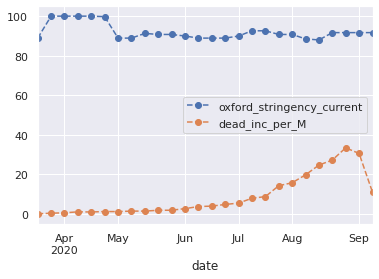

In [60]:

arg_weekly.plot(y=['oxford_stringency_current','dead_inc_per_M'],style='o--')

In [61]:
all_countries = pd.DataFrame()

for c in countries.groups:
    country = countries.get_group(c)
    inc = country['dead'] - country['dead'].shift()
    inc.name='inc'
    country = pd.concat([country,inc],axis=1)
    
    country = country.replace(np.inf,np.nan)
    country = country.dropna()
    all_countries = pd.concat([all_countries,country],axis=0)
    


In [62]:
all_countries.head(50)


date  confirmed   dead  oxford_stringency_current      country  \
226 2020-03-30      114.0    4.0                      67.59  Afghanistan   
227 2020-03-31      141.0    4.0                      67.59  Afghanistan   
228 2020-04-01      166.0    4.0                      67.59  Afghanistan   
229 2020-04-02      192.0    4.0                      67.59  Afghanistan   
230 2020-04-03      235.0    4.0                      67.59  Afghanistan   
231 2020-04-04      235.0    4.0                      67.59  Afghanistan   
232 2020-04-05      270.0    5.0                      78.70  Afghanistan   
233 2020-04-06      299.0    7.0                      78.70  Afghanistan   
234 2020-04-07      337.0    7.0                      78.70  Afghanistan   
235 2020-04-08      367.0   11.0                      78.70  Afghanistan   
236 2020-04-09      423.0   14.0                      78.70  Afghanistan   
237 2020-04-10      484.0   15.0                      78.70  Afghanistan   
238 2020-04-11      521.0   15.0                      78.70  Afghanistan   
239 2020-04-12      555.0   18.0                      84.26  Afghanistan   
240 2020-04-13      607.0   18.0                      84.26  Afghanistan   
241 2020-04-14      665.0   21.0                      84.26  Afghanistan   
242 2020-04-15      714.0   23.0                      84.26  Afghanistan   
243 2020-04-16      784.0   25.0                      84.26  Afghanistan   
244 2020-04-17      794.0   29.0                      84.26  Afghanistan   
245 2020-04-18      845.0   30.0                      84.26  Afghanistan   
246 2020-04-19      908.0   30.0                      84.26  Afghanistan   
247 2020-04-20      996.0   33.0                      84.26  Afghanistan   
248 2020-04-21     1031.0   35.0                      84.26  Afghanistan   
249 2020-04-22     1092.0   36.0                      84.26  Afghanistan   
250 2020-04-23     1176.0   40.0                      84.26  Afghanistan   
251 2020-04-24     1281.0   42.0                      84.26  Afghanistan   
252 2020-04-25     1351.0   43.0                      84.26  Afghanistan   
253 2020-04-26     1463.0   47.0                      84.26  Afghanistan   
254 2020-04-27     1531.0   57.0                      84.26  Afghanistan   
255 2020-04-28     1703.0   57.0                      84.26  Afghanistan   
256 2020-04-29     1827.0   60.0                      84.26  Afghanistan   
257 2020-04-30     1949.0   60.0                      84.26  Afghanistan   
258 2020-05-01     2171.0   64.0                      84.26  Afghanistan   
259 2020-05-02     2335.0   68.0                      84.26  Afghanistan   
260 2020-05-03     2469.0   72.0                      84.26  Afghanistan   
261 2020-05-04     2704.0   85.0                      84.26  Afghanistan   
262 2020-05-05     2894.0   90.0                      84.26  Afghanistan   
263 2020-05-06     3224.0   95.0                      84.26  Afghanistan   
264 2020-05-07     3392.0  104.0                      84.26  Afghanistan   
265 2020-05-08     3563.0  106.0                      84.26  Afghanistan   
266 2020-05-09     3778.0  109.0                      84.26  Afghanistan   
267 2020-05-10     4033.0  115.0                      84.26  Afghanistan   
268 2020-05-11     4402.0  120.0                      84.26  Afghanistan   
269 2020-05-12     4687.0  122.0                      84.26  Afghanistan   
270 2020-05-13     4967.0  127.0                      84.26  Afghanistan   
271 2020-05-14     5226.0  130.0                      84.26  Afghanistan   
272 2020-05-15     5339.0  136.0                      84.26  Afghanistan   
273 2020-05-16     6402.0  168.0                      84.26  Afghanistan   
274 2020-05-17     6402.0  168.0                      84.26  Afghanistan   
275 2020-05-18     6664.0  169.0                      84.26  Afghanistan   

     oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
226               68.872872  38928346    0.102753  AFG        

In [63]:
select_countries = ['Sweden','UK','Spain','Italy','UK','Belgium','France','US','Germany']
select_countries = ['Sweden','UK','Belgium']

### only one country for plotting below

select_countries = ['Australia']

mask = all_countries['country'].isin(select_countries)

selected_countries = (all_countries[mask]).copy()
selected_countries

date  confirmed   dead  oxford_stringency_current    country  \
1555 2020-03-12      126.0    3.0                      19.44  Australia   
1556 2020-03-13      156.0    3.0                      19.44  Australia   
1557 2020-03-14      197.0    3.0                      19.44  Australia   
1558 2020-03-15      249.0    3.0                      19.44  Australia   
1559 2020-03-16      298.0    5.0                      30.56  Australia   
...         ...        ...    ...                        ...        ...   
1736 2020-09-09    26374.0  770.0                      75.46  Australia   
1737 2020-09-10    26465.0  781.0                      75.46  Australia   
1738 2020-09-11    26513.0  788.0                      75.46  Australia   
1739 2020-09-12    26565.0  797.0                      75.46  Australia   
1740 2020-09-13    26607.0  803.0                      75.46  Australia   

      oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
1555               63.883959  25499884    0.117648  AUS            8   
1556               63.883959  25499884    0.117648  AUS            8   
1557               63.883959  25499884    0.117648  AUS            8   
1558               63.883959  25499884    0.117648  AUS            8   
1559               63.883959  25499884    0.196079  AUS            8   
...                      ...       ...         ...  ...          ...   
1736               63.883959  25499884   30.196216  AUS            8   
1737               63.883959  25499884   30.627590  AUS            8   
1738               63.883959  25499884   30.902101  AUS            8   
1739               63.883959  25499884   31.255044  AUS            8   
1740               63.883959  25499884   31.490339  AUS            8   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc   inc  
1555       -0.400176        -2.028329            0.000000   0.0  
1556       -0.400176        -2.028329            0.000000   0.0  
1557       -0.400176        -2.028329            0.000000   0.0  
1558       -0.400176        -2.028329            0.000000   0.0  
1559       -0.399673        -1.522222            0.000503   2.0  
...              ...              ...                 ...   ...  
1736       -0.207237         0.521321            0.002012   8.0  
1737       -0.204470         0.521321            0.002767  11.0  
1738       -0.202710         0.521321            0.001761   7.0  
1739       -0.200446         0.521321            0.002264   9.0  
1740       -0.198936         0.521321            0.001509   6.0  

[186 rows x 14 columns]

In [64]:
unique_country_abbs = selected_countries['abb'].unique()
print (unique_country_abbs)
country_idx = dict(zip(unique_country_abbs,range(1,len(unique_country_abbs) + 1)))
country_idx    

['AUS']


{'AUS': 1}

In [65]:
unique_days = selected_countries['date'].unique()
day_idx = dict(zip(pd.to_datetime(unique_days),range(1,len(unique_days) + 1)))


In [66]:
def create_country_index(abb):
    return country_idx[abb]

def create_day_index(day):
    return day_idx[day]

selected_countries['country_idx'] = selected_countries['abb'].apply(create_country_index)
selected_countries['day_idx'] = selected_countries['date'].apply(create_day_index)
selected_countries['ox_idx'] = selected_countries['oxford_stringency_current'].astype(int)
selected_countries['inc_per_M'] = selected_countries['inc'] / (selected_countries['pop'] / 1e6)
selected_countries

date  confirmed   dead  oxford_stringency_current    country  \
1555 2020-03-12      126.0    3.0                      19.44  Australia   
1556 2020-03-13      156.0    3.0                      19.44  Australia   
1557 2020-03-14      197.0    3.0                      19.44  Australia   
1558 2020-03-15      249.0    3.0                      19.44  Australia   
1559 2020-03-16      298.0    5.0                      30.56  Australia   
...         ...        ...    ...                        ...        ...   
1736 2020-09-09    26374.0  770.0                      75.46  Australia   
1737 2020-09-10    26465.0  781.0                      75.46  Australia   
1738 2020-09-11    26513.0  788.0                      75.46  Australia   
1739 2020-09-12    26565.0  797.0                      75.46  Australia   
1740 2020-09-13    26607.0  803.0                      75.46  Australia   

      oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
1555               63.883959  25499884    0.117648  AUS            1   
1556               63.883959  25499884    0.117648  AUS            1   
1557               63.883959  25499884    0.117648  AUS            1   
1558               63.883959  25499884    0.117648  AUS            1   
1559               63.883959  25499884    0.196079  AUS            1   
...                      ...       ...         ...  ...          ...   
1736               63.883959  25499884   30.196216  AUS            1   
1737               63.883959  25499884   30.627590  AUS            1   
1738               63.883959  25499884   30.902101  AUS            1   
1739               63.883959  25499884   31.255044  AUS            1   
1740               63.883959  25499884   31.490339  AUS            1   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc   inc  day_idx  \
1555       -0.400176        -2.028329            0.000000   0.0        1   
1556       -0.400176        -2.028329            0.000000   0.0        2   
1557       -0.400176        -2.028329            0.000000   0.0        3   
1558       -0.400176        -2.028329            0.000000   0.0        4   
1559       -0.399673        -1.522222            0.000503   2.0        5   
...              ...              ...                 ...   ...      ...   
1736       -0.207237         0.521321            0.002012   8.0      182   
1737       -0.204470         0.521321            0.002767  11.0      183   
1738       -0.202710         0.521321            0.001761   7.0      184   
1739       -0.200446         0.521321            0.002264   9.0      185   
1740       -0.198936         0.521321            0.001509   6.0      186   

      ox_idx  inc_per_M  
1555      19   0.000000  
1556      19   0.000000  
1557      19   0.000000  
1558      19   0.000000  
1559      30   0.078432  
...      ...        ...  
1736      75   0.313727  
1737      75   0.431375  
1738      75   0.274511  
1739      75   0.352943  
1740      75   0.235295  

[186 rows x 17 columns]

In [67]:
selected_period = selected_countries.set_index('date').resample('d').agg({'oxford_stringency_current' : np.mean,
                                                        'inc':np.sum})

selected_period = selected_period[:-1]

In [68]:
def standardize(S):
    return (S - S.mean()) / S.std()

selected_period['date_idx'] = range(1,len(selected_period) + 1)

selected_period['ox_std'] = standardize(selected_period['oxford_stringency_current'])
selected_period['inc_std'] = standardize(selected_period['inc'])
selected_period



oxford_stringency_current   inc  date_idx    ox_std   inc_std
date                                                                     
2020-03-12                      19.44   0.0         1 -3.842279 -0.579342
2020-03-13                      19.44   0.0         2 -3.842279 -0.579342
2020-03-14                      19.44   0.0         3 -3.842279 -0.579342
2020-03-15                      19.44   0.0         4 -3.842279 -0.579342
2020-03-16                      30.56   2.0         5 -2.933676 -0.309371
...                               ...   ...       ...       ...       ...
2020-09-08                      75.46   9.0       181  0.735053  0.635525
2020-09-09                      75.46   8.0       182  0.735053  0.500540
2020-09-10                      75.46  11.0       183  0.735053  0.905495
2020-09-11                      75.46   7.0       184  0.735053  0.365554
2020-09-12                      75.46   9.0       185  0.735053  0.635525

[185 rows x 5 columns]

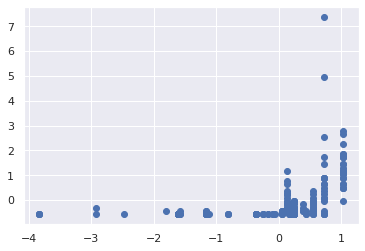

In [69]:
plt.scatter(selected_period['ox_std'],selected_period['inc_std'])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


       mean    sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
alpha  -0.0  0.10     -0.17       0.16        0.0      0.0   1992.39  1604.21   
beta   -0.0  0.10     -0.16       0.17        0.0      0.0   1761.34  1606.05   
sigma   1.0  0.05      0.92       1.08        0.0      0.0   1699.29  1699.29   

       ess_bulk  ess_tail  r_hat  
alpha   1989.29   1965.46    1.0  
beta    1764.09   1589.99    1.0  
sigma   1700.53   1825.34    1.0  


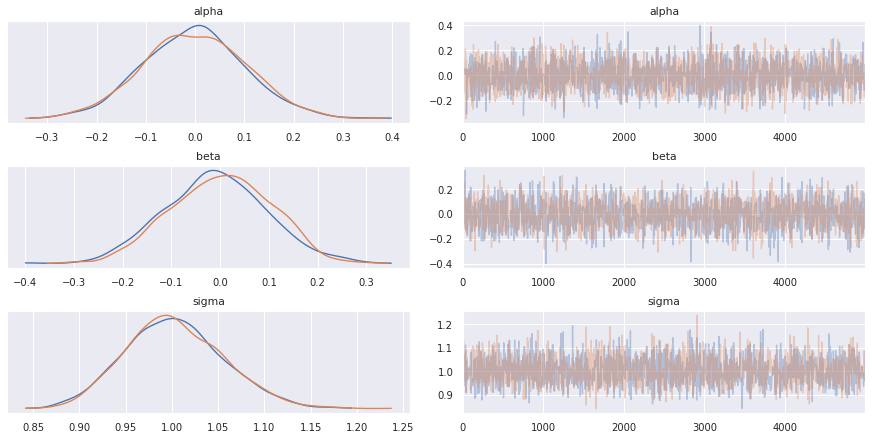

In [70]:
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

model = pm.Model()
with model:
    alpha = pm.Normal('alpha',mu=0,sd=0.1)
    beta = pm.Normal('beta',mu=0,sd=0.1)
    
    sigma = pm.Uniform('sigma',0,10)
    
    reg = alpha + selected_period['ox_std'].values * beta
    
    lkh = pm.Normal('lkh',mu=0,sd=sigma,observed=selected_period['inc_std'])
    
    step1 = pm.Metropolis()
    
    trace = pm.sample(5000,step=step1,tune=5000)
    
    _= az.plot_trace(trace)
    print (az.summary(trace,round_to=2))
    

In [71]:
result = pm.trace_to_dataframe(trace)
result.describe()

alpha          beta         sigma
count  10000.000000  10000.000000  10000.000000
mean      -0.001115     -0.003403      1.003088
std        0.103384      0.103089      0.052233
min       -0.344235     -0.399633      0.841635
25%       -0.070420     -0.073455      0.965883
50%       -0.001001     -0.002764      1.000683
75%        0.066348      0.068074      1.037378
max        0.397703      0.351173      1.237053

In [72]:
nr_rows = 1000

X = np.linspace(selected_period['ox_std'].min(),selected_period['ox_std'].max(),nr_rows)

rows = np.random.choice(result.index,replace=True,size=nr_rows)

lines = np.array([ result.iloc[i]['alpha'] + X * result.iloc[i]['beta'] for i in range(nr_rows)])

lines

array([[-0.14786413, -0.1475444 , -0.14722466, ...,  0.17090925,
         0.17122899,  0.17154872],
       [-0.18109465, -0.18071897, -0.18034329, ...,  0.1934548 ,
         0.19383047,  0.19420615],
       [-0.18109465, -0.18071897, -0.18034329, ...,  0.1934548 ,
         0.19383047,  0.19420615],
       ...,
       [ 0.55321795,  0.55252675,  0.55183556, ..., -0.13590196,
        -0.13659315, -0.13728434],
       [-0.43906723, -0.43849675, -0.43792628, ...,  0.1296926 ,
         0.13026307,  0.13083354],
       [ 0.34822249,  0.34779194,  0.3473614 , ..., -0.08103297,
        -0.08146352, -0.08189407]])

/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 0, 'Mean Oxford index for period [standardized]')

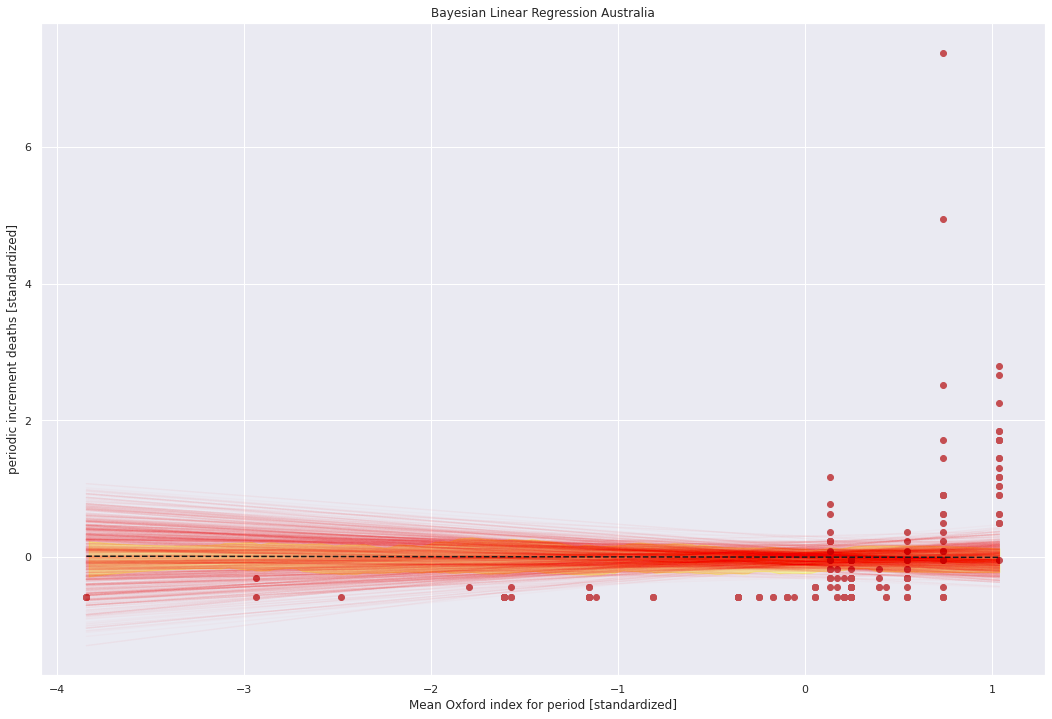

In [73]:
plt.figure(figsize=(18,12))

ax = plt.gca()

plt.title('Bayesian Linear Regression {}'.format(select_countries[0]))

_= [plt.plot(X,lines[i],color='red',alpha=0.02) for i in range(nr_rows)]

plt.plot(X,result.describe().loc['mean','alpha'] + result.describe().loc['mean','beta'] * X,
         '--',color='k')

fill_kwargs = {'alpha': 0.3}
az.plot_hpd(X, lines.T,ax=ax,color='yellow',fill_kwargs=fill_kwargs)


plt.scatter(selected_period['ox_std'],selected_period['inc_std'],color='r')
plt.ylabel('periodic increment deaths [standardized]')
plt.xlabel('Mean Oxford index for period [standardized]')



In [74]:
selected_period

oxford_stringency_current   inc  date_idx    ox_std   inc_std
date                                                                     
2020-03-12                      19.44   0.0         1 -3.842279 -0.579342
2020-03-13                      19.44   0.0         2 -3.842279 -0.579342
2020-03-14                      19.44   0.0         3 -3.842279 -0.579342
2020-03-15                      19.44   0.0         4 -3.842279 -0.579342
2020-03-16                      30.56   2.0         5 -2.933676 -0.309371
...                               ...   ...       ...       ...       ...
2020-09-08                      75.46   9.0       181  0.735053  0.635525
2020-09-09                      75.46   8.0       182  0.735053  0.500540
2020-09-10                      75.46  11.0       183  0.735053  0.905495
2020-09-11                      75.46   7.0       184  0.735053  0.365554
2020-09-12                      75.46   9.0       185  0.735053  0.635525

[185 rows x 5 columns]

In [75]:
selected_countries

date  confirmed   dead  oxford_stringency_current    country  \
1555 2020-03-12      126.0    3.0                      19.44  Australia   
1556 2020-03-13      156.0    3.0                      19.44  Australia   
1557 2020-03-14      197.0    3.0                      19.44  Australia   
1558 2020-03-15      249.0    3.0                      19.44  Australia   
1559 2020-03-16      298.0    5.0                      30.56  Australia   
...         ...        ...    ...                        ...        ...   
1736 2020-09-09    26374.0  770.0                      75.46  Australia   
1737 2020-09-10    26465.0  781.0                      75.46  Australia   
1738 2020-09-11    26513.0  788.0                      75.46  Australia   
1739 2020-09-12    26565.0  797.0                      75.46  Australia   
1740 2020-09-13    26607.0  803.0                      75.46  Australia   

      oxford_stringency_mean       pop  dead_per_M  abb  country_idx  \
1555               63.883959  25499884    0.117648  AUS            1   
1556               63.883959  25499884    0.117648  AUS            1   
1557               63.883959  25499884    0.117648  AUS            1   
1558               63.883959  25499884    0.117648  AUS            1   
1559               63.883959  25499884    0.196079  AUS            1   
...                      ...       ...         ...  ...          ...   
1736               63.883959  25499884   30.196216  AUS            1   
1737               63.883959  25499884   30.627590  AUS            1   
1738               63.883959  25499884   30.902101  AUS            1   
1739               63.883959  25499884   31.255044  AUS            1   
1740               63.883959  25499884   31.490339  AUS            1   

      dead_per_M_std  oxford_curr_std  dead_per_M_std_inc   inc  day_idx  \
1555       -0.400176        -2.028329            0.000000   0.0        1   
1556       -0.400176        -2.028329            0.000000   0.0        2   
1557       -0.400176        -2.028329            0.000000   0.0        3   
1558       -0.400176        -2.028329            0.000000   0.0        4   
1559       -0.399673        -1.522222            0.000503   2.0        5   
...              ...              ...                 ...   ...      ...   
1736       -0.207237         0.521321            0.002012   8.0      182   
1737       -0.204470         0.521321            0.002767  11.0      183   
1738       -0.202710         0.521321            0.001761   7.0      184   
1739       -0.200446         0.521321            0.002264   9.0      185   
1740       -0.198936         0.521321            0.001509   6.0      186   

      ox_idx  inc_per_M  
1555      19   0.000000  
1556      19   0.000000  
1557      19   0.000000  
1558      19   0.000000  
1559      30   0.078432  
...      ...        ...  
1736      75   0.313727  
1737      75   0.431375  
1738      75   0.274511  
1739      75   0.352943  
1740      75   0.235295  

[186 rows x 17 columns]